In [1]:
%matplotlib inline


# LDA Model

Introduces Gensim's LDA model and demonstrates its use on the NIPS corpus.


In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [87]:
import json
dataset_path = "/home/ralf/IdeaProjects/LitBall-training/EXP-Title+TLDR/"
text_key = "preprocessedText"
docs = []
with open(dataset_path + "ROTVRSV") as file:
    lines = file.readlines()
    for line in lines:
        d = json.loads(line)
        docs.append(d[text_key])

tdocs = []
with open(dataset_path + "DENV") as file:
    lines = file.readlines()
    for line in lines:
        d = json.loads(line)
        tdocs.append(d[text_key])

        # Tokenize the documents.

        from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.
for idx in range(len(tdocs)):
    tdocs[idx] = tdocs[idx].lower()  # Convert to lowercase.
    tdocs[idx] = tokenizer.tokenize(tdocs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
tdocs = [[token for token in doc if not token.isnumeric()] for doc in tdocs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]
tdocs = [[token for token in doc if len(token) > 1] for doc in tdocs]

print(len(docs))
print(docs[0][:500])
print(len(tdocs))
print(tdocs[0][:500])

22996
['carbocisteine', 'inhibit', 'respiratory', 'syncytial', 'virus', 'infection', 'human', 'tracheal', 'epithelial', 'cell', 'it', 'be', 'suggest', 'carbocisteine', 'may', 'inhibit', 'rs', 'virus', 'infection', 'reduce', 'expression', 'icam', 'rs', 'virus', 'receptor', 'it', 'may', 'also', 'modulate', 'airway', 'inflammation', 'rsirus', 'infection']
8679
['vitro', 'effect', 'human', 'cathelicidin', 'antimicrobial', 'peptide', 'll', 'dengue', 'virus', 'type', 'vitro', 'experiment', 'silico', 'analysis', 'suggest', 'll', 'inhibit', 'dengue', 'virus', 'type', 'denv', 'infection', 'replication', 'vero', 'e6', 'cell', 'bind', 'protein']


In [88]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
bads = ["in", "it", "may", "also", "that", "which", "will", "not", "have", "use"]
dictionary.filter_tokens(bad_ids=[dictionary.token2id[tok] for tok in bads])

# Bag-of-words representation of the documents.
tr_corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(tr_corpus))
te_corpus = [dictionary.doc2bow(doc) for doc in tdocs]
print('Number of test documents: %d' % len(te_corpus))
print(te_corpus[500])

2023-07-16 19:52:09,072 : INFO : collecting all words and their counts
2023-07-16 19:52:09,073 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2023-07-16 19:52:09,383 : INFO : PROGRESS: at sentence #10000, processed 333429 words and 196775 word types
2023-07-16 19:52:09,667 : INFO : PROGRESS: at sentence #20000, processed 663196 words and 334553 word types
2023-07-16 19:52:09,769 : INFO : collected 371705 token types (unigram + bigrams) from a corpus of 760288 words and 22996 sentences
2023-07-16 19:52:09,769 : INFO : merged Phrases<371705 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>
2023-07-16 19:52:09,770 : INFO : Phrases lifecycle event {'msg': 'built Phrases<371705 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000> in 0.70s', 'datetime': '2023-07-16T19:52:09.770646', 'gensim': '4.3.1', 'python': '3.11.4 (main, Jul  6 2023, 12:44:45) [GCC 7.5.0]', 'platform': 'Linux-5.14.21-150400.24.66-default-x86_64-with-glibc2.31', 'event': 'creat

Number of unique tokens: 3973
Number of documents: 22996
Number of test documents: 8679
[(8, 1), (22, 1), (38, 3), (74, 1), (251, 1), (258, 1), (279, 1), (463, 1), (493, 2), (512, 1), (531, 1), (578, 1), (704, 1), (738, 1), (933, 1), (934, 1), (1428, 1), (1477, 1), (1649, 1), (2186, 3), (2468, 1), (3006, 1)]


In [90]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 50
chunksize = 2000
passes = 30
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

2023-07-16 19:53:11,059 : INFO : using autotuned alpha, starting with [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
2023-07-16 19:53:11,064 : INFO : using serial LDA version on this node
2023-07-16 19:53:11,097 : INFO : running online (multi-pass) LDA training, 50 topics, 30 passes over the supplied corpus of 22996 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2023-07-16 19:53:11,097 : INFO : PROGRESS: pass 0, at document #2000/22996
2023-07-16 19:53:12,437 : INFO : optimized alpha [0.018962191, 0.018608306, 0.018726913, 0.019038837, 0.018812487, 0.018845163, 0.018899526, 0.01874824, 0.018866101, 0.018930525, 0.018661205, 0.018715499

2023-07-16 19:53:14,472 : INFO : topic #41 (0.021): 0.046*"death" + 0.037*"rsv" + 0.035*"rs" + 0.034*"infection" + 0.025*"major" + 0.021*"sars" + 0.020*"phase" + 0.019*"rs_virus" + 0.019*"syncytial" + 0.017*"virus"
2023-07-16 19:53:14,473 : INFO : topic #44 (0.021): 0.058*"review" + 0.017*"current" + 0.016*"alteration" + 0.015*"vaccine_development" + 0.014*"virus" + 0.014*"severe_acute" + 0.013*"infection" + 0.012*"clinical" + 0.012*"downstream" + 0.012*"sort"
2023-07-16 19:53:14,474 : INFO : topic #7 (0.022): 0.084*"leukemia" + 0.083*"rotavirus" + 0.026*"might" + 0.024*"human" + 0.024*"observation" + 0.022*"absorption" + 0.022*"gene" + 0.018*"china" + 0.016*"shed_light" + 0.016*"choriomeningitis"
2023-07-16 19:53:14,474 : INFO : topic diff=0.150054, rho=0.500000
2023-07-16 19:53:14,486 : INFO : PROGRESS: pass 0, at document #10000/22996
2023-07-16 19:53:15,051 : INFO : optimized alpha [0.021192458, 0.019720355, 0.02056849, 0.020548856, 0.019699, 0.02051978, 0.019653752, 0.02238062, 0.

2023-07-16 19:53:16,857 : INFO : topic #6 (0.020): 0.031*"virus" + 0.018*"infection" + 0.015*"hela" + 0.015*"obstructive" + 0.014*"certain" + 0.014*"month_old" + 0.014*"cis" + 0.013*"considerably" + 0.012*"rabv" + 0.012*"understanding_how"
2023-07-16 19:53:16,858 : INFO : topic #13 (0.024): 0.080*"cell" + 0.037*"infection" + 0.025*"epithelial" + 0.024*"intestinal_mucosa" + 0.023*"production" + 0.021*"expression" + 0.018*"plasma" + 0.016*"cytokine" + 0.015*"activation" + 0.014*"it_be"
2023-07-16 19:53:16,858 : INFO : topic #41 (0.024): 0.046*"death" + 0.042*"infection" + 0.037*"rsv" + 0.037*"phase" + 0.034*"rs" + 0.023*"sars" + 0.023*"major" + 0.016*"virus" + 0.016*"attributable" + 0.016*"associated"
2023-07-16 19:53:16,859 : INFO : topic #44 (0.027): 0.093*"review" + 0.019*"alteration" + 0.018*"downstream" + 0.017*"development" + 0.016*"current" + 0.016*"severe_acute" + 0.015*"major" + 0.014*"purpose" + 0.013*"infection" + 0.012*"new"
2023-07-16 19:53:16,860 : INFO : topic diff=0.13934

2023-07-16 19:53:18,874 : INFO : topic #34 (0.021): 0.068*"barrier" + 0.037*"human" + 0.027*"bioinformatics" + 0.027*"milk" + 0.022*"birth_cohort" + 0.021*"guinea_pig" + 0.016*"learning" + 0.015*"threat" + 0.014*"young_infant" + 0.012*"avian_metapneumovirus"
2023-07-16 19:53:18,874 : INFO : topic #41 (0.028): 0.049*"death" + 0.048*"infection" + 0.040*"phase" + 0.034*"rs" + 0.029*"rsv" + 0.028*"major" + 0.027*"sars" + 0.019*"very" + 0.017*"sequela" + 0.017*"attributable"
2023-07-16 19:53:18,875 : INFO : topic #46 (0.030): 0.115*"rs" + 0.107*"rsv" + 0.103*"syncytial" + 0.101*"rs_virus" + 0.097*"virus" + 0.023*"infection" + 0.010*"human" + 0.009*"storm" + 0.008*"pre" + 0.008*"hrsv"
2023-07-16 19:53:18,875 : INFO : topic #44 (0.035): 0.112*"review" + 0.033*"alteration" + 0.019*"downstream" + 0.018*"current" + 0.017*"development" + 0.016*"major" + 0.015*"virus" + 0.015*"severe_acute" + 0.014*"work" + 0.014*"infection"
2023-07-16 19:53:18,876 : INFO : topic diff=0.200674, rho=0.288675
2023-0

2023-07-16 19:53:21,162 : INFO : topic #42 (0.022): 0.104*"only" + 0.083*"virus" + 0.055*"yeast" + 0.035*"infection" + 0.026*"emphasize" + 0.022*"measles" + 0.018*"alteration" + 0.018*"asymptomatic" + 0.018*"nonstructural_protein" + 0.017*"selective"
2023-07-16 19:53:21,162 : INFO : topic #41 (0.031): 0.055*"death" + 0.045*"phase" + 0.044*"infection" + 0.028*"rs" + 0.028*"major" + 0.027*"sars" + 0.024*"rsv" + 0.020*"sequela" + 0.019*"very" + 0.018*"accelerate"
2023-07-16 19:53:21,163 : INFO : topic #46 (0.034): 0.123*"rs" + 0.110*"rsv" + 0.109*"syncytial" + 0.108*"rs_virus" + 0.102*"virus" + 0.022*"infection" + 0.012*"human" + 0.009*"hrsv" + 0.008*"storm" + 0.007*"point"
2023-07-16 19:53:21,164 : INFO : topic #44 (0.041): 0.108*"review" + 0.026*"alteration" + 0.020*"current" + 0.020*"downstream" + 0.019*"development" + 0.015*"major" + 0.014*"new" + 0.014*"rich" + 0.014*"work" + 0.013*"virus"
2023-07-16 19:53:21,164 : INFO : topic diff=0.235563, rho=0.272186
2023-07-16 19:53:21,172 : IN

2023-07-16 19:53:23,388 : INFO : topic #42 (0.023): 0.127*"only" + 0.099*"virus" + 0.072*"yeast" + 0.034*"infection" + 0.023*"measles" + 0.020*"emphasize" + 0.018*"selective" + 0.017*"alteration" + 0.017*"nonstructural_protein" + 0.015*"asymptomatic"
2023-07-16 19:53:23,389 : INFO : topic #41 (0.035): 0.055*"phase" + 0.053*"death" + 0.044*"infection" + 0.025*"sars" + 0.025*"major" + 0.023*"sequela" + 0.022*"rsv" + 0.021*"rs" + 0.019*"nasal" + 0.018*"attributable"
2023-07-16 19:53:23,389 : INFO : topic #46 (0.040): 0.133*"rs" + 0.119*"rsv" + 0.110*"syncytial" + 0.109*"rs_virus" + 0.107*"virus" + 0.025*"infection" + 0.014*"human" + 0.010*"hrsv" + 0.010*"storm" + 0.008*"pre"
2023-07-16 19:53:23,390 : INFO : topic #44 (0.049): 0.118*"review" + 0.024*"alteration" + 0.022*"downstream" + 0.020*"development" + 0.019*"purpose" + 0.018*"current" + 0.016*"major" + 0.015*"new" + 0.014*"rich" + 0.014*"work"
2023-07-16 19:53:23,391 : INFO : topic diff=0.237850, rho=0.272186
2023-07-16 19:53:23,401 :

2023-07-16 19:53:25,287 : INFO : topic #42 (0.024): 0.132*"only" + 0.130*"virus" + 0.071*"yeast" + 0.030*"infection" + 0.026*"nonstructural_protein" + 0.023*"alteration" + 0.021*"measles" + 0.018*"emphasize" + 0.017*"bring" + 0.015*"selective"
2023-07-16 19:53:25,288 : INFO : topic #41 (0.039): 0.054*"death" + 0.053*"phase" + 0.048*"infection" + 0.029*"sars" + 0.028*"major" + 0.024*"sequela" + 0.021*"very" + 0.020*"rs" + 0.020*"nasal" + 0.018*"high"
2023-07-16 19:53:25,289 : INFO : topic #46 (0.047): 0.143*"rs" + 0.122*"rsv" + 0.119*"virus" + 0.116*"syncytial" + 0.114*"rs_virus" + 0.029*"infection" + 0.014*"human" + 0.009*"hrsv" + 0.008*"dataset" + 0.007*"storm"
2023-07-16 19:53:25,289 : INFO : topic #44 (0.061): 0.130*"review" + 0.038*"alteration" + 0.022*"downstream" + 0.019*"current" + 0.018*"development" + 0.017*"major" + 0.016*"virus" + 0.016*"purpose" + 0.015*"work" + 0.015*"new"
2023-07-16 19:53:25,290 : INFO : topic diff=0.231792, rho=0.272186
2023-07-16 19:53:25,300 : INFO : P

2023-07-16 19:53:27,396 : INFO : topic #42 (0.025): 0.129*"virus" + 0.119*"only" + 0.064*"yeast" + 0.030*"infection" + 0.028*"emphasize" + 0.024*"measles" + 0.020*"nonstructural_protein" + 0.019*"asymptomatic" + 0.019*"premature" + 0.019*"selective"
2023-07-16 19:53:27,397 : INFO : topic #41 (0.043): 0.057*"death" + 0.055*"phase" + 0.044*"infection" + 0.029*"sars" + 0.028*"major" + 0.025*"sequela" + 0.020*"nasal" + 0.020*"very" + 0.019*"attributable" + 0.019*"high"
2023-07-16 19:53:27,397 : INFO : topic #46 (0.054): 0.143*"rs" + 0.120*"rsv" + 0.119*"virus" + 0.118*"syncytial" + 0.117*"rs_virus" + 0.028*"infection" + 0.014*"human" + 0.010*"hrsv" + 0.007*"dataset" + 0.006*"monkey"
2023-07-16 19:53:27,398 : INFO : topic #44 (0.068): 0.124*"review" + 0.030*"alteration" + 0.022*"downstream" + 0.021*"current" + 0.020*"development" + 0.016*"major" + 0.015*"new" + 0.015*"work" + 0.015*"rich" + 0.014*"ph"
2023-07-16 19:53:27,399 : INFO : topic diff=0.183099, rho=0.262631
2023-07-16 19:53:27,409

2023-07-16 19:53:29,501 : INFO : topic #24 (0.027): 0.045*"kinase" + 0.027*"situ" + 0.025*"virus" + 0.024*"variable" + 0.018*"week" + 0.017*"lipid_raft" + 0.016*"case_control" + 0.016*"play_key" + 0.015*"intestinal_mucosa" + 0.015*"it_be"
2023-07-16 19:53:29,501 : INFO : topic #41 (0.047): 0.063*"phase" + 0.054*"death" + 0.044*"infection" + 0.027*"sequela" + 0.026*"sars" + 0.025*"major" + 0.020*"high" + 0.020*"nasal" + 0.019*"attributable" + 0.018*"very"
2023-07-16 19:53:29,502 : INFO : topic #46 (0.061): 0.146*"rs" + 0.128*"rsv" + 0.120*"virus" + 0.115*"syncytial" + 0.114*"rs_virus" + 0.031*"infection" + 0.017*"human" + 0.010*"hrsv" + 0.009*"dataset" + 0.006*"monkey"
2023-07-16 19:53:29,503 : INFO : topic #44 (0.080): 0.132*"review" + 0.027*"alteration" + 0.024*"downstream" + 0.020*"development" + 0.019*"purpose" + 0.019*"current" + 0.017*"major" + 0.015*"new" + 0.015*"work" + 0.014*"infection"
2023-07-16 19:53:29,503 : INFO : topic diff=0.141718, rho=0.262631
2023-07-16 19:53:29,513 

2023-07-16 19:53:31,305 : INFO : topic #24 (0.028): 0.044*"kinase" + 0.032*"virus" + 0.027*"situ" + 0.020*"variable" + 0.019*"nonsegmented" + 0.018*"lipid_raft" + 0.017*"week" + 0.017*"young_child" + 0.016*"ifn" + 0.016*"hmgb1"
2023-07-16 19:53:31,306 : INFO : topic #26 (0.052): 0.068*"target" + 0.048*"severe_acute" + 0.046*"world" + 0.041*"clear" + 0.032*"drug" + 0.031*"metabolic" + 0.025*"therapy" + 0.022*"stem_cell" + 0.019*"novel" + 0.018*"weight"
2023-07-16 19:53:31,306 : INFO : topic #46 (0.069): 0.153*"rs" + 0.129*"rsv" + 0.128*"virus" + 0.118*"syncytial" + 0.116*"rs_virus" + 0.034*"infection" + 0.015*"human" + 0.009*"dataset" + 0.009*"hrsv" + 0.006*"outbreak"
2023-07-16 19:53:31,307 : INFO : topic #44 (0.095): 0.143*"review" + 0.041*"alteration" + 0.023*"downstream" + 0.019*"current" + 0.018*"major" + 0.017*"development" + 0.017*"virus" + 0.016*"infection" + 0.016*"purpose" + 0.015*"work"
2023-07-16 19:53:31,308 : INFO : topic diff=0.134773, rho=0.262631
2023-07-16 19:53:31,317

2023-07-16 19:53:33,326 : INFO : topic #42 (0.029): 0.155*"virus" + 0.118*"only" + 0.063*"yeast" + 0.027*"emphasize" + 0.027*"infection" + 0.025*"premature" + 0.023*"measles" + 0.020*"nonstructural_protein" + 0.019*"asymptomatic" + 0.018*"selective"
2023-07-16 19:53:33,326 : INFO : topic #26 (0.056): 0.062*"target" + 0.048*"severe_acute" + 0.047*"world" + 0.046*"clear" + 0.038*"drug" + 0.025*"metabolic" + 0.025*"therapy" + 0.022*"novel" + 0.020*"stem_cell" + 0.019*"sort"
2023-07-16 19:53:33,327 : INFO : topic #46 (0.076): 0.151*"rs" + 0.127*"rsv" + 0.127*"virus" + 0.119*"syncytial" + 0.118*"rs_virus" + 0.032*"infection" + 0.016*"human" + 0.010*"hrsv" + 0.008*"dataset" + 0.006*"monkey"
2023-07-16 19:53:33,328 : INFO : topic #44 (0.102): 0.137*"review" + 0.032*"alteration" + 0.023*"downstream" + 0.021*"current" + 0.019*"development" + 0.017*"major" + 0.015*"infection" + 0.015*"virus" + 0.015*"work" + 0.015*"ph"
2023-07-16 19:53:33,329 : INFO : topic diff=0.105833, rho=0.254017
2023-07-16

2023-07-16 19:53:35,248 : INFO : topic #24 (0.031): 0.048*"kinase" + 0.031*"situ" + 0.027*"virus" + 0.026*"variable" + 0.018*"week" + 0.017*"lipid_raft" + 0.017*"it_be" + 0.016*"case_control" + 0.016*"intestinal_mucosa" + 0.016*"absorption"
2023-07-16 19:53:35,248 : INFO : topic #26 (0.063): 0.063*"target" + 0.049*"world" + 0.049*"severe_acute" + 0.046*"clear" + 0.038*"drug" + 0.028*"therapy" + 0.024*"stem_cell" + 0.023*"metabolic" + 0.022*"novel" + 0.020*"sort"
2023-07-16 19:53:35,249 : INFO : topic #46 (0.083): 0.152*"rs" + 0.134*"rsv" + 0.126*"virus" + 0.115*"syncytial" + 0.114*"rs_virus" + 0.035*"infection" + 0.018*"human" + 0.010*"hrsv" + 0.010*"dataset" + 0.006*"monkey"
2023-07-16 19:53:35,249 : INFO : topic #44 (0.115): 0.143*"review" + 0.029*"alteration" + 0.024*"downstream" + 0.019*"current" + 0.019*"purpose" + 0.018*"development" + 0.018*"major" + 0.016*"infection" + 0.015*"tlr" + 0.014*"new"
2023-07-16 19:53:35,250 : INFO : topic diff=0.083999, rho=0.254017
2023-07-16 19:53:

2023-07-16 19:53:36,928 : INFO : topic #24 (0.032): 0.046*"kinase" + 0.035*"virus" + 0.030*"situ" + 0.022*"variable" + 0.021*"ifn" + 0.018*"nonsegmented" + 0.018*"lipid_raft" + 0.017*"week" + 0.017*"absorption" + 0.017*"young_child"
2023-07-16 19:53:36,929 : INFO : topic #26 (0.069): 0.075*"target" + 0.052*"severe_acute" + 0.050*"world" + 0.045*"clear" + 0.034*"drug" + 0.031*"metabolic" + 0.028*"therapy" + 0.024*"stem_cell" + 0.021*"novel" + 0.021*"weight"
2023-07-16 19:53:36,930 : INFO : topic #46 (0.092): 0.158*"rs" + 0.133*"rsv" + 0.132*"virus" + 0.118*"syncytial" + 0.115*"rs_virus" + 0.038*"infection" + 0.016*"human" + 0.010*"dataset" + 0.009*"hrsv" + 0.006*"outbreak"
2023-07-16 19:53:36,930 : INFO : topic #44 (0.132): 0.152*"review" + 0.043*"alteration" + 0.023*"downstream" + 0.019*"major" + 0.018*"current" + 0.018*"infection" + 0.018*"virus" + 0.017*"tlr" + 0.016*"development" + 0.015*"purpose"
2023-07-16 19:53:36,931 : INFO : topic diff=0.091235, rho=0.254017
2023-07-16 19:53:36

2023-07-16 19:53:38,770 : INFO : topic #42 (0.033): 0.167*"virus" + 0.116*"only" + 0.062*"yeast" + 0.030*"engineered" + 0.029*"premature" + 0.026*"emphasize" + 0.024*"infection" + 0.023*"measles" + 0.019*"nonstructural_protein" + 0.019*"progeny"
2023-07-16 19:53:38,771 : INFO : topic #26 (0.074): 0.068*"target" + 0.050*"world" + 0.050*"severe_acute" + 0.050*"clear" + 0.039*"drug" + 0.028*"therapy" + 0.025*"metabolic" + 0.024*"novel" + 0.022*"stem_cell" + 0.020*"sort"
2023-07-16 19:53:38,772 : INFO : topic #46 (0.098): 0.155*"rs" + 0.131*"rsv" + 0.131*"virus" + 0.119*"syncytial" + 0.117*"rs_virus" + 0.035*"infection" + 0.016*"human" + 0.010*"hrsv" + 0.009*"dataset" + 0.006*"monkey"
2023-07-16 19:53:38,772 : INFO : topic #44 (0.137): 0.145*"review" + 0.035*"alteration" + 0.023*"downstream" + 0.021*"current" + 0.018*"major" + 0.017*"development" + 0.017*"infection" + 0.016*"virus" + 0.015*"ph" + 0.015*"tlr"
2023-07-16 19:53:38,773 : INFO : topic diff=0.072930, rho=0.246198
2023-07-16 19:5

2023-07-16 19:53:40,590 : INFO : topic #24 (0.035): 0.048*"kinase" + 0.033*"situ" + 0.030*"virus" + 0.027*"variable" + 0.018*"it_be" + 0.018*"week" + 0.018*"ifn" + 0.017*"lipid_raft" + 0.017*"absorption" + 0.016*"case_control"
2023-07-16 19:53:40,591 : INFO : topic #26 (0.081): 0.068*"target" + 0.051*"world" + 0.051*"severe_acute" + 0.049*"clear" + 0.039*"drug" + 0.030*"therapy" + 0.025*"stem_cell" + 0.025*"novel" + 0.023*"metabolic" + 0.022*"sort"
2023-07-16 19:53:40,591 : INFO : topic #46 (0.104): 0.154*"rs" + 0.138*"rsv" + 0.129*"virus" + 0.115*"syncytial" + 0.114*"rs_virus" + 0.037*"infection" + 0.018*"human" + 0.010*"dataset" + 0.010*"hrsv" + 0.006*"monkey"
2023-07-16 19:53:40,592 : INFO : topic #44 (0.150): 0.151*"review" + 0.031*"alteration" + 0.024*"downstream" + 0.019*"major" + 0.019*"current" + 0.018*"purpose" + 0.018*"infection" + 0.017*"development" + 0.016*"tlr" + 0.015*"egress"
2023-07-16 19:53:40,593 : INFO : topic diff=0.058815, rho=0.246198
2023-07-16 19:53:40,603 : IN

2023-07-16 19:53:42,177 : INFO : topic #24 (0.037): 0.047*"kinase" + 0.037*"virus" + 0.032*"situ" + 0.023*"ifn" + 0.023*"variable" + 0.018*"absorption" + 0.018*"nonsegmented" + 0.018*"young_child" + 0.018*"lipid_raft" + 0.017*"it_be"
2023-07-16 19:53:42,177 : INFO : topic #26 (0.086): 0.080*"target" + 0.054*"severe_acute" + 0.051*"world" + 0.048*"clear" + 0.035*"drug" + 0.030*"metabolic" + 0.029*"therapy" + 0.026*"stem_cell" + 0.023*"novel" + 0.022*"weight"
2023-07-16 19:53:42,178 : INFO : topic #46 (0.112): 0.160*"rs" + 0.136*"rsv" + 0.134*"virus" + 0.118*"syncytial" + 0.115*"rs_virus" + 0.040*"infection" + 0.016*"human" + 0.010*"dataset" + 0.009*"hrsv" + 0.006*"outbreak"
2023-07-16 19:53:42,178 : INFO : topic #44 (0.168): 0.158*"review" + 0.045*"alteration" + 0.023*"downstream" + 0.020*"infection" + 0.020*"major" + 0.019*"virus" + 0.018*"current" + 0.017*"tlr" + 0.015*"development" + 0.015*"purpose"
2023-07-16 19:53:42,179 : INFO : topic diff=0.071877, rho=0.246198
2023-07-16 19:53:4

2023-07-16 19:53:43,975 : INFO : topic #42 (0.038): 0.174*"virus" + 0.115*"only" + 0.062*"yeast" + 0.035*"engineered" + 0.033*"premature" + 0.026*"emphasize" + 0.024*"infection" + 0.022*"measles" + 0.020*"progeny" + 0.019*"nonstructural_protein"
2023-07-16 19:53:43,976 : INFO : topic #26 (0.091): 0.071*"target" + 0.053*"clear" + 0.052*"world" + 0.052*"severe_acute" + 0.040*"drug" + 0.029*"therapy" + 0.026*"novel" + 0.025*"metabolic" + 0.023*"stem_cell" + 0.021*"sort"
2023-07-16 19:53:43,976 : INFO : topic #46 (0.117): 0.157*"rs" + 0.134*"rsv" + 0.133*"virus" + 0.119*"syncytial" + 0.117*"rs_virus" + 0.037*"infection" + 0.017*"human" + 0.010*"hrsv" + 0.009*"dataset" + 0.006*"monkey"
2023-07-16 19:53:43,976 : INFO : topic #44 (0.171): 0.152*"review" + 0.036*"alteration" + 0.023*"downstream" + 0.020*"current" + 0.020*"major" + 0.019*"infection" + 0.017*"virus" + 0.016*"development" + 0.015*"tlr" + 0.015*"ph"
2023-07-16 19:53:43,977 : INFO : topic diff=0.058618, rho=0.239059
2023-07-16 19:5

2023-07-16 19:53:45,736 : INFO : topic #24 (0.040): 0.048*"kinase" + 0.035*"situ" + 0.032*"virus" + 0.027*"variable" + 0.019*"it_be" + 0.018*"ifn" + 0.018*"week" + 0.017*"absorption" + 0.017*"lipid_raft" + 0.016*"young_child"
2023-07-16 19:53:45,736 : INFO : topic #26 (0.098): 0.072*"target" + 0.052*"severe_acute" + 0.051*"world" + 0.050*"clear" + 0.039*"drug" + 0.032*"therapy" + 0.027*"novel" + 0.026*"stem_cell" + 0.023*"metabolic" + 0.022*"sort"
2023-07-16 19:53:45,737 : INFO : topic #46 (0.123): 0.156*"rs" + 0.141*"rsv" + 0.130*"virus" + 0.115*"syncytial" + 0.114*"rs_virus" + 0.039*"infection" + 0.018*"human" + 0.010*"dataset" + 0.010*"hrsv" + 0.006*"monkey"
2023-07-16 19:53:45,737 : INFO : topic #44 (0.182): 0.156*"review" + 0.033*"alteration" + 0.024*"downstream" + 0.020*"major" + 0.019*"infection" + 0.018*"current" + 0.018*"purpose" + 0.016*"development" + 0.016*"tlr" + 0.015*"virus"
2023-07-16 19:53:45,738 : INFO : topic diff=0.046918, rho=0.239059
2023-07-16 19:53:45,747 : INFO

2023-07-16 19:53:47,242 : INFO : topic #49 (0.041): 0.061*"infectivity" + 0.050*"microtubule" + 0.046*"fix" + 0.038*"cd4_cd8" + 0.032*"acid" + 0.029*"formalin" + 0.029*"nanoparticle" + 0.027*"bud" + 0.025*"self" + 0.025*"elevate"
2023-07-16 19:53:47,242 : INFO : topic #26 (0.103): 0.083*"target" + 0.055*"severe_acute" + 0.052*"world" + 0.050*"clear" + 0.035*"drug" + 0.031*"therapy" + 0.030*"metabolic" + 0.026*"stem_cell" + 0.025*"novel" + 0.023*"weight"
2023-07-16 19:53:47,243 : INFO : topic #46 (0.130): 0.161*"rs" + 0.138*"rsv" + 0.136*"virus" + 0.117*"syncytial" + 0.115*"rs_virus" + 0.042*"infection" + 0.017*"human" + 0.010*"dataset" + 0.009*"hrsv" + 0.006*"outbreak"
2023-07-16 19:53:47,244 : INFO : topic #44 (0.202): 0.162*"review" + 0.047*"alteration" + 0.023*"downstream" + 0.021*"infection" + 0.021*"major" + 0.019*"virus" + 0.018*"tlr" + 0.018*"current" + 0.015*"work" + 0.015*"ph"
2023-07-16 19:53:47,244 : INFO : topic diff=0.062460, rho=0.239059
2023-07-16 19:53:47,254 : INFO : P

2023-07-16 19:53:48,775 : INFO : topic #24 (0.042): 0.041*"situ" + 0.039*"kinase" + 0.034*"virus" + 0.027*"variable" + 0.021*"cancer" + 0.020*"young_child" + 0.018*"lipid_raft" + 0.018*"it_be" + 0.018*"week" + 0.017*"absorption"
2023-07-16 19:53:48,776 : INFO : topic #26 (0.107): 0.074*"target" + 0.054*"clear" + 0.052*"severe_acute" + 0.052*"world" + 0.040*"drug" + 0.030*"therapy" + 0.027*"novel" + 0.025*"metabolic" + 0.024*"stem_cell" + 0.021*"sort"
2023-07-16 19:53:48,776 : INFO : topic #46 (0.134): 0.158*"rs" + 0.136*"rsv" + 0.134*"virus" + 0.119*"syncytial" + 0.117*"rs_virus" + 0.039*"infection" + 0.017*"human" + 0.009*"hrsv" + 0.009*"dataset" + 0.006*"monkey"
2023-07-16 19:53:48,777 : INFO : topic #44 (0.202): 0.156*"review" + 0.038*"alteration" + 0.023*"downstream" + 0.020*"major" + 0.020*"infection" + 0.019*"current" + 0.017*"virus" + 0.016*"tlr" + 0.016*"development" + 0.015*"egress"
2023-07-16 19:53:48,777 : INFO : topic diff=0.051479, rho=0.232508
2023-07-16 19:53:48,788 : IN

2023-07-16 19:53:50,313 : INFO : topic #14 (0.044): 0.065*"severe" + 0.057*"rs" + 0.056*"accelerate" + 0.055*"cell_culture" + 0.051*"recognition" + 0.045*"sars" + 0.045*"models" + 0.029*"sars_cov" + 0.028*"create" + 0.027*"pathogen"
2023-07-16 19:53:50,314 : INFO : topic #26 (0.115): 0.074*"target" + 0.053*"severe_acute" + 0.052*"clear" + 0.052*"world" + 0.039*"drug" + 0.034*"therapy" + 0.028*"novel" + 0.027*"stem_cell" + 0.022*"sort" + 0.022*"metabolic"
2023-07-16 19:53:50,314 : INFO : topic #46 (0.139): 0.157*"rs" + 0.142*"rsv" + 0.132*"virus" + 0.115*"syncytial" + 0.114*"rs_virus" + 0.040*"infection" + 0.018*"human" + 0.010*"dataset" + 0.010*"hrsv" + 0.006*"monkey"
2023-07-16 19:53:50,315 : INFO : topic #44 (0.213): 0.160*"review" + 0.034*"alteration" + 0.024*"downstream" + 0.021*"major" + 0.020*"infection" + 0.018*"current" + 0.017*"purpose" + 0.016*"tlr" + 0.016*"virus" + 0.016*"development"
2023-07-16 19:53:50,316 : INFO : topic diff=0.040681, rho=0.232508
2023-07-16 19:53:50,324

2023-07-16 19:53:51,638 : INFO : topic #14 (0.045): 0.060*"accelerate" + 0.059*"severe" + 0.052*"cell_culture" + 0.051*"rs" + 0.049*"sars" + 0.045*"recognition" + 0.038*"models" + 0.030*"sars_cov" + 0.025*"create" + 0.025*"treatment"
2023-07-16 19:53:51,638 : INFO : topic #26 (0.119): 0.084*"target" + 0.057*"severe_acute" + 0.052*"world" + 0.051*"clear" + 0.035*"drug" + 0.032*"therapy" + 0.029*"metabolic" + 0.027*"stem_cell" + 0.026*"novel" + 0.023*"weight"
2023-07-16 19:53:51,639 : INFO : topic #46 (0.146): 0.163*"rs" + 0.139*"rsv" + 0.137*"virus" + 0.117*"syncytial" + 0.115*"rs_virus" + 0.043*"infection" + 0.017*"human" + 0.010*"dataset" + 0.009*"hrsv" + 0.006*"outbreak"
2023-07-16 19:53:51,639 : INFO : topic #44 (0.235): 0.165*"review" + 0.048*"alteration" + 0.023*"downstream" + 0.022*"infection" + 0.021*"major" + 0.020*"virus" + 0.018*"tlr" + 0.017*"current" + 0.015*"asthmatic" + 0.015*"work"
2023-07-16 19:53:51,640 : INFO : topic diff=0.056711, rho=0.232508
2023-07-16 19:53:51,652

2023-07-16 19:53:53,152 : INFO : topic #14 (0.046): 0.061*"severe" + 0.059*"cell_culture" + 0.056*"accelerate" + 0.052*"rs" + 0.049*"sars" + 0.044*"recognition" + 0.036*"create" + 0.036*"models" + 0.029*"sars_cov" + 0.028*"admit"
2023-07-16 19:53:53,153 : INFO : topic #26 (0.123): 0.075*"target" + 0.055*"clear" + 0.053*"severe_acute" + 0.053*"world" + 0.039*"drug" + 0.031*"therapy" + 0.029*"novel" + 0.024*"stem_cell" + 0.024*"metabolic" + 0.021*"sort"
2023-07-16 19:53:53,153 : INFO : topic #46 (0.149): 0.159*"rs" + 0.137*"rsv" + 0.136*"virus" + 0.119*"syncytial" + 0.117*"rs_virus" + 0.040*"infection" + 0.017*"human" + 0.009*"hrsv" + 0.009*"dataset" + 0.006*"monkey"
2023-07-16 19:53:53,154 : INFO : topic #44 (0.232): 0.159*"review" + 0.039*"alteration" + 0.023*"downstream" + 0.021*"major" + 0.021*"infection" + 0.019*"current" + 0.018*"virus" + 0.016*"tlr" + 0.015*"development" + 0.015*"egress"
2023-07-16 19:53:53,154 : INFO : topic diff=0.046447, rho=0.226467
2023-07-16 19:53:53,164 : I

2023-07-16 19:53:54,687 : INFO : topic #49 (0.048): 0.067*"infectivity" + 0.051*"cd4_cd8" + 0.048*"microtubule" + 0.043*"fix" + 0.039*"nanoparticle" + 0.031*"acid" + 0.027*"formalin" + 0.025*"bud" + 0.025*"elevate" + 0.025*"self"
2023-07-16 19:53:54,688 : INFO : topic #26 (0.130): 0.075*"target" + 0.054*"severe_acute" + 0.053*"clear" + 0.052*"world" + 0.038*"drug" + 0.034*"therapy" + 0.029*"novel" + 0.027*"stem_cell" + 0.022*"sort" + 0.022*"metabolic"
2023-07-16 19:53:54,688 : INFO : topic #46 (0.153): 0.158*"rs" + 0.143*"rsv" + 0.133*"virus" + 0.115*"syncytial" + 0.114*"rs_virus" + 0.041*"infection" + 0.019*"human" + 0.011*"dataset" + 0.010*"hrsv" + 0.006*"monkey"
2023-07-16 19:53:54,689 : INFO : topic #44 (0.242): 0.162*"review" + 0.035*"alteration" + 0.024*"downstream" + 0.022*"major" + 0.021*"infection" + 0.018*"current" + 0.017*"purpose" + 0.017*"virus" + 0.016*"tlr" + 0.015*"development"
2023-07-16 19:53:54,689 : INFO : topic diff=0.036082, rho=0.226467
2023-07-16 19:53:54,699 : 

2023-07-16 19:53:56,060 : INFO : topic #26 (0.134): 0.085*"target" + 0.058*"severe_acute" + 0.052*"world" + 0.052*"clear" + 0.035*"drug" + 0.033*"therapy" + 0.029*"metabolic" + 0.028*"stem_cell" + 0.027*"novel" + 0.023*"weight"
2023-07-16 19:53:56,060 : INFO : topic #46 (0.159): 0.164*"rs" + 0.140*"rsv" + 0.138*"virus" + 0.118*"syncytial" + 0.116*"rs_virus" + 0.044*"infection" + 0.017*"human" + 0.010*"dataset" + 0.009*"hrsv" + 0.006*"outbreak"
2023-07-16 19:53:56,061 : INFO : topic #44 (0.264): 0.165*"review" + 0.049*"alteration" + 0.023*"infection" + 0.022*"downstream" + 0.022*"major" + 0.020*"virus" + 0.018*"tlr" + 0.017*"current" + 0.016*"asthmatic" + 0.015*"work"
2023-07-16 19:53:56,062 : INFO : topic diff=0.052671, rho=0.226467
2023-07-16 19:53:56,072 : INFO : PROGRESS: pass 8, at document #2000/22996
2023-07-16 19:53:56,438 : INFO : optimized alpha [0.09038799, 0.07494634, 0.13349093, 0.11824336, 0.0521326, 0.07388181, 0.05257566, 0.08679461, 0.08465727, 0.07427531, 0.08616175, 0

2023-07-16 19:53:57,621 : INFO : topic #46 (0.162): 0.160*"rs" + 0.138*"rsv" + 0.137*"virus" + 0.119*"syncytial" + 0.118*"rs_virus" + 0.041*"infection" + 0.017*"human" + 0.009*"hrsv" + 0.009*"dataset" + 0.006*"monkey"
2023-07-16 19:53:57,621 : INFO : topic #44 (0.260): 0.159*"review" + 0.041*"alteration" + 0.022*"downstream" + 0.022*"infection" + 0.021*"major" + 0.019*"virus" + 0.019*"current" + 0.016*"tlr" + 0.015*"development" + 0.014*"egress"
2023-07-16 19:53:57,622 : INFO : topic diff=0.043019, rho=0.220874
2023-07-16 19:53:57,632 : INFO : PROGRESS: pass 8, at document #10000/22996
2023-07-16 19:53:57,999 : INFO : optimized alpha [0.09347881, 0.07560863, 0.13659583, 0.1232744, 0.053511232, 0.07667083, 0.05452505, 0.09129393, 0.088448174, 0.07750587, 0.08714286, 0.0533203, 0.088937804, 0.10243837, 0.050337035, 0.08461234, 0.08348285, 0.09558582, 0.0671637, 0.06855328, 0.081579834, 0.08089302, 0.07035463, 0.08033712, 0.051881567, 0.092259556, 0.13813497, 0.10943583, 0.08327046, 0.071

2023-07-16 19:53:59,204 : INFO : topic #46 (0.165): 0.159*"rs" + 0.143*"rsv" + 0.134*"virus" + 0.115*"syncytial" + 0.114*"rs_virus" + 0.042*"infection" + 0.019*"human" + 0.011*"dataset" + 0.010*"hrsv" + 0.006*"monkey"
2023-07-16 19:53:59,205 : INFO : topic #44 (0.270): 0.161*"review" + 0.036*"alteration" + 0.023*"downstream" + 0.022*"infection" + 0.022*"major" + 0.017*"current" + 0.017*"virus" + 0.017*"purpose" + 0.016*"tlr" + 0.015*"development"
2023-07-16 19:53:59,206 : INFO : topic diff=0.033302, rho=0.220874
2023-07-16 19:53:59,218 : INFO : PROGRESS: pass 8, at document #18000/22996
2023-07-16 19:53:59,590 : INFO : optimized alpha [0.09453183, 0.07912739, 0.1417958, 0.12944715, 0.055072505, 0.07884213, 0.056117468, 0.092332534, 0.08956379, 0.08056211, 0.09118668, 0.05433214, 0.08991205, 0.10775696, 0.05147985, 0.08781585, 0.0848432, 0.098812066, 0.06838932, 0.07049664, 0.08175113, 0.0825696, 0.071216345, 0.0829525, 0.053944305, 0.095122814, 0.14261284, 0.11317705, 0.08663346, 0.072

2023-07-16 19:54:00,604 : INFO : topic #44 (0.293): 0.164*"review" + 0.050*"alteration" + 0.024*"infection" + 0.022*"major" + 0.022*"downstream" + 0.021*"virus" + 0.018*"tlr" + 0.017*"current" + 0.016*"asthmatic" + 0.015*"work"
2023-07-16 19:54:00,605 : INFO : topic diff=0.049956, rho=0.220874
2023-07-16 19:54:00,614 : INFO : PROGRESS: pass 9, at document #2000/22996
2023-07-16 19:54:00,986 : INFO : optimized alpha [0.09737471, 0.082108825, 0.1499482, 0.13171847, 0.056058347, 0.0802186, 0.057441805, 0.093239374, 0.09195173, 0.084224015, 0.092360064, 0.055394582, 0.09163676, 0.10805486, 0.052643184, 0.08921272, 0.08787344, 0.1010951, 0.06930488, 0.072552584, 0.08342469, 0.08549539, 0.073165044, 0.08562536, 0.0552764, 0.09767907, 0.1498375, 0.11518934, 0.08795148, 0.07542527, 0.09274159, 0.06917515, 0.08004503, 0.07213757, 0.054342505, 0.06350897, 0.07993773, 0.07831774, 0.055735208, 0.09636439, 0.062250987, 0.116323076, 0.054409277, 0.065493725, 0.29060432, 0.08515007, 0.17278343, 0.104

2023-07-16 19:54:02,177 : INFO : topic diff=0.040986, rho=0.215676
2023-07-16 19:54:02,188 : INFO : PROGRESS: pass 9, at document #10000/22996
2023-07-16 19:54:02,545 : INFO : optimized alpha [0.100238696, 0.08251135, 0.15268752, 0.13650444, 0.057342473, 0.08286989, 0.05934702, 0.09765416, 0.09550538, 0.08756706, 0.092925854, 0.05685587, 0.095389515, 0.108733766, 0.053745467, 0.09146779, 0.09006078, 0.10262518, 0.07156902, 0.07409962, 0.08699237, 0.08629049, 0.07522175, 0.08863317, 0.056117836, 0.10133486, 0.15091129, 0.11687802, 0.08905743, 0.077231444, 0.09596137, 0.07100137, 0.08284961, 0.07419755, 0.056281544, 0.0653966, 0.081982315, 0.080383964, 0.05710913, 0.098809026, 0.06432306, 0.11934032, 0.05588595, 0.067167796, 0.28771403, 0.08871512, 0.1735463, 0.10697596, 0.074390754, 0.053941414]
2023-07-16 19:54:02,554 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:02,562 : INFO : topic #14 (0.054): 0.059*"severe" + 0.058*"cell_culture" + 0

2023-07-16 19:54:03,699 : INFO : topic diff=0.031524, rho=0.215676
2023-07-16 19:54:03,709 : INFO : PROGRESS: pass 9, at document #18000/22996
2023-07-16 19:54:04,050 : INFO : optimized alpha [0.10078748, 0.086030886, 0.15791623, 0.14240655, 0.058798485, 0.08487336, 0.060842454, 0.098460704, 0.09620284, 0.09060226, 0.09678264, 0.057778027, 0.09604952, 0.114055485, 0.054701954, 0.094345436, 0.09107159, 0.10550643, 0.07265778, 0.07601278, 0.08684893, 0.08774221, 0.07589851, 0.09111067, 0.058118112, 0.103784494, 0.1548024, 0.12043751, 0.09234881, 0.078917734, 0.09877325, 0.07230583, 0.083521, 0.07584881, 0.056896593, 0.06684712, 0.08401942, 0.08143425, 0.058105104, 0.10160871, 0.065781936, 0.124423996, 0.057349823, 0.06815742, 0.29985103, 0.090195715, 0.18601122, 0.10978509, 0.075498, 0.055501554]
2023-07-16 19:54:04,057 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:04,065 : INFO : topic #14 (0.055): 0.066*"severe" + 0.055*"accelerate" + 0.0

2023-07-16 19:54:05,042 : INFO : PROGRESS: pass 10, at document #2000/22996
2023-07-16 19:54:05,378 : INFO : optimized alpha [0.10328197, 0.088916525, 0.16600904, 0.14406514, 0.059657745, 0.08597091, 0.062073406, 0.09902483, 0.098287195, 0.094155595, 0.0976297, 0.05872934, 0.09752024, 0.114018925, 0.055763748, 0.09536445, 0.09395489, 0.10737315, 0.073413745, 0.078087844, 0.088301435, 0.09050056, 0.07772834, 0.09372042, 0.059382856, 0.106062666, 0.16166194, 0.12223625, 0.09343237, 0.081414364, 0.09843531, 0.07370265, 0.08477768, 0.076607406, 0.05787276, 0.06812039, 0.086208574, 0.08339308, 0.059365526, 0.10251926, 0.067376055, 0.123415165, 0.05811378, 0.069571584, 0.32090312, 0.091066904, 0.18360251, 0.114328615, 0.07698192, 0.056148984]
2023-07-16 19:54:05,386 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:05,395 : INFO : topic #14 (0.056): 0.065*"accelerate" + 0.063*"severe" + 0.056*"cell_culture" + 0.053*"sars" + 0.051*"rs" + 0.050*"reco

2023-07-16 19:54:06,933 : INFO : optimized alpha [0.10584748, 0.089051485, 0.1685949, 0.1484562, 0.060825158, 0.088390164, 0.06393138, 0.10336498, 0.10179368, 0.09748835, 0.09787863, 0.060115162, 0.10109787, 0.11442122, 0.056761704, 0.097464114, 0.09594147, 0.10854304, 0.07556872, 0.07966057, 0.091722146, 0.09107302, 0.07965458, 0.09698062, 0.060127083, 0.109771796, 0.16192585, 0.12367336, 0.0942833, 0.08307499, 0.101601996, 0.07541232, 0.08746676, 0.078502215, 0.059731826, 0.06984015, 0.087910004, 0.08530474, 0.060674988, 0.104717866, 0.06937063, 0.12604594, 0.059472114, 0.07113755, 0.31818715, 0.09443645, 0.18392803, 0.11601846, 0.079474986, 0.057125073]
2023-07-16 19:54:06,940 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:06,948 : INFO : topic #14 (0.057): 0.060*"severe" + 0.059*"cell_culture" + 0.053*"recognition" + 0.051*"accelerate" + 0.050*"sars" + 0.048*"rs" + 0.036*"models" + 0.034*"surface_glycoprotein" + 0.030*"admit" + 0.030*"

2023-07-16 19:54:08,442 : INFO : optimized alpha [0.10618545, 0.0925693, 0.17412513, 0.1544434, 0.062176388, 0.09015938, 0.06529258, 0.10399396, 0.102198906, 0.10051331, 0.10152049, 0.06093926, 0.10138912, 0.11986885, 0.057608098, 0.10016933, 0.096707396, 0.111246556, 0.07649981, 0.08154712, 0.09130927, 0.09231454, 0.08016163, 0.09992132, 0.062079076, 0.112009436, 0.1651949, 0.12700701, 0.09742186, 0.08459809, 0.10431679, 0.0765184, 0.08792559, 0.08003637, 0.060240865, 0.071106896, 0.08974611, 0.08618558, 0.061625462, 0.10726713, 0.070737064, 0.13103455, 0.060833666, 0.071974434, 0.3314106, 0.09564238, 0.19661175, 0.11861318, 0.08037634, 0.058621366]
2023-07-16 19:54:08,450 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:08,459 : INFO : topic #14 (0.058): 0.067*"severe" + 0.056*"recognition" + 0.055*"accelerate" + 0.053*"rs" + 0.052*"cell_culture" + 0.051*"sars" + 0.042*"models" + 0.029*"create" + 0.029*"sars_cov" + 0.026*"admit"
2023-07-16

2023-07-16 19:54:09,750 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:09,758 : INFO : topic #14 (0.059): 0.065*"accelerate" + 0.063*"severe" + 0.057*"cell_culture" + 0.054*"sars" + 0.052*"recognition" + 0.050*"rs" + 0.040*"models" + 0.031*"sars_cov" + 0.028*"six" + 0.027*"create"
2023-07-16 19:54:09,759 : INFO : topic #49 (0.059): 0.057*"infectivity" + 0.051*"microtubule" + 0.046*"fix" + 0.034*"cd4_cd8" + 0.034*"nanoparticle" + 0.033*"acid" + 0.026*"formalin" + 0.026*"elevate" + 0.026*"bud" + 0.026*"experimental"
2023-07-16 19:54:09,759 : INFO : topic #2 (0.183): 0.221*"absorption" + 0.064*"time" + 0.060*"alteration" + 0.047*"fusion" + 0.046*"virus" + 0.026*"domain" + 0.022*"it_be" + 0.018*"generally" + 0.018*"mammalian" + 0.016*"bind"
2023-07-16 19:54:09,760 : INFO : topic #46 (0.194): 0.163*"rs" + 0.146*"rsv" + 0.141*"virus" + 0.119*"syncytial" + 0.117*"rs_virus" + 0.045*"infection" + 0.017*"human" + 0.009*"dataset" + 0.008*"hrsv" + 0.0

2023-07-16 19:54:11,260 : INFO : topic #14 (0.059): 0.061*"severe" + 0.059*"cell_culture" + 0.054*"recognition" + 0.052*"accelerate" + 0.050*"sars" + 0.046*"rs" + 0.037*"models" + 0.034*"surface_glycoprotein" + 0.031*"admit" + 0.031*"create"
2023-07-16 19:54:11,261 : INFO : topic #49 (0.060): 0.054*"fix" + 0.049*"microtubule" + 0.048*"infectivity" + 0.035*"cd4_cd8" + 0.031*"nanoparticle" + 0.029*"formalin" + 0.029*"acid" + 0.027*"site" + 0.027*"bud" + 0.026*"self"
2023-07-16 19:54:11,261 : INFO : topic #2 (0.185): 0.227*"absorption" + 0.063*"time" + 0.056*"alteration" + 0.050*"fusion" + 0.044*"virus" + 0.027*"domain" + 0.022*"it_be" + 0.019*"generally" + 0.017*"mammalian" + 0.017*"bind"
2023-07-16 19:54:11,262 : INFO : topic #46 (0.194): 0.163*"rs" + 0.139*"virus" + 0.139*"rsv" + 0.118*"syncytial" + 0.117*"rs_virus" + 0.044*"infection" + 0.020*"human" + 0.010*"dataset" + 0.010*"hrsv" + 0.006*"outbreak"
2023-07-16 19:54:11,262 : INFO : topic #44 (0.352): 0.149*"review" + 0.045*"alterati

2023-07-16 19:54:12,721 : INFO : topic #49 (0.062): 0.066*"infectivity" + 0.048*"cd4_cd8" + 0.047*"microtubule" + 0.044*"fix" + 0.038*"nanoparticle" + 0.030*"acid" + 0.027*"formalin" + 0.026*"bud" + 0.024*"self" + 0.023*"site"
2023-07-16 19:54:12,722 : INFO : topic #2 (0.191): 0.231*"absorption" + 0.068*"time" + 0.057*"alteration" + 0.046*"fusion" + 0.045*"virus" + 0.025*"domain" + 0.022*"it_be" + 0.018*"bind" + 0.017*"generally" + 0.016*"mammalian"
2023-07-16 19:54:12,723 : INFO : topic #46 (0.206): 0.165*"rs" + 0.146*"rsv" + 0.139*"virus" + 0.121*"syncytial" + 0.120*"rs_virus" + 0.045*"infection" + 0.016*"human" + 0.011*"dataset" + 0.008*"hrsv" + 0.006*"outbreak"
2023-07-16 19:54:12,723 : INFO : topic #44 (0.367): 0.156*"review" + 0.041*"alteration" + 0.025*"infection" + 0.024*"major" + 0.021*"downstream" + 0.019*"virus" + 0.016*"asthmatic" + 0.016*"development" + 0.016*"current" + 0.015*"new"
2023-07-16 19:54:12,723 : INFO : topic diff=0.046977, rho=0.206293
2023-07-16 19:54:12,733 

2023-07-16 19:54:14,022 : INFO : topic #2 (0.200): 0.229*"absorption" + 0.062*"time" + 0.058*"alteration" + 0.046*"fusion" + 0.046*"virus" + 0.026*"domain" + 0.022*"it_be" + 0.018*"mammalian" + 0.018*"generally" + 0.016*"bind"
2023-07-16 19:54:14,023 : INFO : topic #46 (0.203): 0.164*"rs" + 0.147*"rsv" + 0.142*"virus" + 0.119*"syncytial" + 0.117*"rs_virus" + 0.045*"infection" + 0.017*"human" + 0.010*"dataset" + 0.008*"hrsv" + 0.006*"outbreak"
2023-07-16 19:54:14,024 : INFO : topic #44 (0.392): 0.150*"review" + 0.052*"alteration" + 0.025*"infection" + 0.023*"major" + 0.022*"virus" + 0.020*"downstream" + 0.016*"tlr" + 0.016*"asthmatic" + 0.015*"work" + 0.015*"current"
2023-07-16 19:54:14,024 : INFO : topic diff=0.031142, rho=0.202039
2023-07-16 19:54:14,036 : INFO : PROGRESS: pass 12, at document #4000/22996
2023-07-16 19:54:14,368 : INFO : optimized alpha [0.11482337, 0.10138226, 0.20145607, 0.16933683, 0.06606019, 0.09608212, 0.07089544, 0.10946699, 0.10992769, 0.11362324, 0.10598293, 

2023-07-16 19:54:15,508 : INFO : topic #46 (0.203): 0.163*"rs" + 0.140*"virus" + 0.139*"rsv" + 0.119*"syncytial" + 0.118*"rs_virus" + 0.044*"infection" + 0.020*"human" + 0.010*"dataset" + 0.010*"hrsv" + 0.006*"outbreak"
2023-07-16 19:54:15,509 : INFO : topic #44 (0.390): 0.144*"review" + 0.046*"alteration" + 0.026*"infection" + 0.023*"major" + 0.020*"downstream" + 0.020*"virus" + 0.017*"tlr" + 0.016*"current" + 0.016*"development" + 0.015*"work"
2023-07-16 19:54:15,509 : INFO : topic diff=0.031613, rho=0.202039
2023-07-16 19:54:15,519 : INFO : PROGRESS: pass 12, at document #12000/22996
2023-07-16 19:54:15,860 : INFO : optimized alpha [0.11662406, 0.10291036, 0.20459805, 0.17588985, 0.067306615, 0.0980267, 0.072512284, 0.11255763, 0.11239426, 0.11723847, 0.105759405, 0.066221274, 0.11037628, 0.12818643, 0.062381584, 0.10757127, 0.10640644, 0.11916009, 0.08217114, 0.09088554, 0.09886686, 0.099418975, 0.0874505, 0.11474416, 0.06812751, 0.12564656, 0.18211924, 0.13699949, 0.10420724, 0.09

2023-07-16 19:54:17,031 : INFO : topic #44 (0.406): 0.151*"review" + 0.042*"alteration" + 0.026*"infection" + 0.024*"major" + 0.021*"downstream" + 0.020*"virus" + 0.016*"asthmatic" + 0.016*"development" + 0.016*"new" + 0.015*"current"
2023-07-16 19:54:17,032 : INFO : topic diff=0.045512, rho=0.202039
2023-07-16 19:54:17,041 : INFO : PROGRESS: pass 12, at document #20000/22996
2023-07-16 19:54:17,380 : INFO : optimized alpha [0.11680099, 0.10421877, 0.21269776, 0.17712767, 0.068133034, 0.0997718, 0.07398919, 0.114247315, 0.11250502, 0.120081834, 0.10926467, 0.06696828, 0.11091408, 0.13066754, 0.063122794, 0.10937762, 0.10817024, 0.12093181, 0.08340981, 0.09249684, 0.09892236, 0.10195663, 0.08887695, 0.11659372, 0.06926171, 0.12677929, 0.18396492, 0.13738635, 0.10639339, 0.0958501, 0.11321293, 0.08368343, 0.09618632, 0.08671662, 0.06655298, 0.07872769, 0.10035302, 0.09561333, 0.06827286, 0.11674419, 0.08033311, 0.14217763, 0.067146815, 0.079284325, 0.40465456, 0.10474504, 0.21359044, 0.1

2023-07-16 19:54:18,344 : INFO : topic diff=0.029845, rho=0.198037
2023-07-16 19:54:18,354 : INFO : PROGRESS: pass 13, at document #4000/22996
2023-07-16 19:54:18,683 : INFO : optimized alpha [0.11923373, 0.106467426, 0.21907659, 0.18075305, 0.06873692, 0.10019106, 0.07465472, 0.1139419, 0.11433712, 0.12238607, 0.109534584, 0.0672832, 0.11161219, 0.13121422, 0.06397112, 0.10951857, 0.109338105, 0.122809336, 0.08406121, 0.0944113, 0.1001668, 0.102805614, 0.08954705, 0.11770071, 0.06998816, 0.12905394, 0.18908274, 0.13882397, 0.106965825, 0.097321115, 0.11248084, 0.084846675, 0.09638489, 0.08758885, 0.067257315, 0.07921534, 0.101024136, 0.09628679, 0.06991724, 0.116937585, 0.08141531, 0.14167267, 0.06769193, 0.08009426, 0.4339256, 0.10525697, 0.21039234, 0.13930233, 0.09039964, 0.06468858]
2023-07-16 19:54:18,691 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:18,698 : INFO : topic #14 (0.064): 0.064*"severe" + 0.059*"accelerate" + 0.055*"cel

2023-07-16 19:54:19,819 : INFO : PROGRESS: pass 13, at document #12000/22996
2023-07-16 19:54:20,159 : INFO : optimized alpha [0.12086204, 0.10788691, 0.22205281, 0.18745609, 0.06988989, 0.10202773, 0.076152846, 0.11703533, 0.11663835, 0.12598372, 0.10911999, 0.068736896, 0.11434244, 0.13361871, 0.06469592, 0.11161021, 0.111085534, 0.12354566, 0.08501007, 0.095436715, 0.10222214, 0.10285572, 0.09072008, 0.120369226, 0.07127796, 0.13315818, 0.19005777, 0.1416236, 0.1082339, 0.09806457, 0.114631645, 0.08584858, 0.09847811, 0.08904623, 0.06902243, 0.080934286, 0.10263996, 0.09786306, 0.070708, 0.11898772, 0.08296103, 0.14284173, 0.06899094, 0.08112769, 0.43433565, 0.10817499, 0.21056788, 0.14172378, 0.09153661, 0.06542188]
2023-07-16 19:54:20,167 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:20,176 : INFO : topic #14 (0.065): 0.062*"severe" + 0.059*"cell_culture" + 0.056*"recognition" + 0.052*"accelerate" + 0.047*"sars" + 0.043*"rs" + 0.038*

2023-07-16 19:54:21,600 : INFO : optimized alpha [0.12086826, 0.109079994, 0.23019853, 0.18868236, 0.0706374, 0.1037102, 0.07754912, 0.11860759, 0.11662777, 0.12848656, 0.11257967, 0.06939507, 0.1147602, 0.13593915, 0.06537824, 0.11326257, 0.112758026, 0.12522534, 0.08611203, 0.096794896, 0.102140024, 0.10527907, 0.09203255, 0.12168126, 0.07230546, 0.13393377, 0.19149373, 0.141817, 0.11033905, 0.10004822, 0.11702817, 0.08654624, 0.09927289, 0.08968399, 0.06916592, 0.08175223, 0.10409872, 0.09933318, 0.071196415, 0.12092552, 0.08423279, 0.14755064, 0.06977391, 0.08210815, 0.44694915, 0.10846838, 0.22225699, 0.14217433, 0.093253, 0.06702781]
2023-07-16 19:54:21,607 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:21,615 : INFO : topic #14 (0.065): 0.071*"severe" + 0.060*"sars" + 0.058*"cell_culture" + 0.057*"recognition" + 0.056*"accelerate" + 0.050*"rs" + 0.046*"models" + 0.036*"sars_cov" + 0.033*"six" + 0.031*"create"
2023-07-16 19:54:21,616

2023-07-16 19:54:22,867 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:22,876 : INFO : topic #14 (0.066): 0.065*"severe" + 0.058*"accelerate" + 0.056*"cell_culture" + 0.056*"recognition" + 0.051*"sars" + 0.045*"rs" + 0.040*"models" + 0.036*"six" + 0.032*"create" + 0.032*"sars_cov"
2023-07-16 19:54:22,876 : INFO : topic #49 (0.067): 0.055*"infectivity" + 0.051*"fix" + 0.048*"microtubule" + 0.033*"cd4_cd8" + 0.033*"nanoparticle" + 0.032*"acid" + 0.029*"bud" + 0.027*"formalin" + 0.027*"site" + 0.025*"self"
2023-07-16 19:54:22,877 : INFO : topic #46 (0.219): 0.166*"rs" + 0.146*"rsv" + 0.144*"virus" + 0.120*"syncytial" + 0.118*"rs_virus" + 0.044*"infection" + 0.017*"human" + 0.011*"dataset" + 0.009*"hrsv" + 0.006*"outbreak"
2023-07-16 19:54:22,877 : INFO : topic #2 (0.237): 0.241*"absorption" + 0.059*"time" + 0.055*"alteration" + 0.047*"fusion" + 0.046*"virus" + 0.025*"domain" + 0.023*"it_be" + 0.019*"mammalian" + 0.018*"generally" + 0.017*"bin

2023-07-16 19:54:24,327 : INFO : topic #14 (0.067): 0.062*"severe" + 0.059*"cell_culture" + 0.056*"recognition" + 0.051*"accelerate" + 0.048*"sars" + 0.043*"rs" + 0.038*"models" + 0.033*"create" + 0.032*"six" + 0.032*"surface_glycoprotein"
2023-07-16 19:54:24,328 : INFO : topic #49 (0.068): 0.053*"fix" + 0.051*"infectivity" + 0.046*"microtubule" + 0.037*"nanoparticle" + 0.034*"bud" + 0.030*"cd4_cd8" + 0.029*"site" + 0.028*"formalin" + 0.028*"acid" + 0.027*"useful"
2023-07-16 19:54:24,328 : INFO : topic #46 (0.219): 0.166*"rs" + 0.142*"virus" + 0.141*"rsv" + 0.120*"syncytial" + 0.118*"rs_virus" + 0.046*"infection" + 0.019*"human" + 0.011*"dataset" + 0.010*"hrsv" + 0.006*"outbreak"
2023-07-16 19:54:24,329 : INFO : topic #2 (0.239): 0.244*"absorption" + 0.062*"time" + 0.052*"alteration" + 0.047*"fusion" + 0.045*"virus" + 0.025*"domain" + 0.022*"it_be" + 0.019*"mammalian" + 0.018*"bind" + 0.016*"generally"
2023-07-16 19:54:24,330 : INFO : topic #44 (0.479): 0.135*"review" + 0.048*"alterati

2023-07-16 19:54:25,794 : INFO : topic #49 (0.069): 0.059*"infectivity" + 0.051*"fix" + 0.050*"microtubule" + 0.046*"cd4_cd8" + 0.038*"nanoparticle" + 0.029*"self" + 0.029*"acid" + 0.029*"formalin" + 0.026*"bud" + 0.024*"site"
2023-07-16 19:54:25,795 : INFO : topic #46 (0.231): 0.165*"rs" + 0.146*"rsv" + 0.142*"virus" + 0.122*"syncytial" + 0.121*"rs_virus" + 0.045*"infection" + 0.016*"human" + 0.011*"dataset" + 0.009*"hrsv" + 0.006*"monkey"
2023-07-16 19:54:25,795 : INFO : topic #2 (0.248): 0.244*"absorption" + 0.060*"time" + 0.050*"alteration" + 0.045*"virus" + 0.045*"fusion" + 0.028*"domain" + 0.022*"it_be" + 0.019*"bind" + 0.017*"generally" + 0.017*"structure"
2023-07-16 19:54:25,796 : INFO : topic #44 (0.492): 0.138*"review" + 0.043*"alteration" + 0.027*"infection" + 0.025*"major" + 0.021*"virus" + 0.018*"downstream" + 0.017*"new" + 0.017*"development" + 0.016*"asthmatic" + 0.015*"immunology"
2023-07-16 19:54:25,797 : INFO : topic diff=0.037499, rho=0.194265
2023-07-16 19:54:25,806

2023-07-16 19:54:27,087 : INFO : topic #46 (0.227): 0.166*"rs" + 0.146*"rsv" + 0.145*"virus" + 0.120*"syncytial" + 0.118*"rs_virus" + 0.044*"infection" + 0.017*"human" + 0.011*"dataset" + 0.009*"hrsv" + 0.006*"outbreak"
2023-07-16 19:54:27,088 : INFO : topic #2 (0.254): 0.244*"absorption" + 0.058*"time" + 0.054*"alteration" + 0.046*"fusion" + 0.046*"virus" + 0.025*"domain" + 0.024*"it_be" + 0.019*"mammalian" + 0.018*"bind" + 0.018*"generally"
2023-07-16 19:54:27,088 : INFO : topic #44 (0.525): 0.134*"review" + 0.053*"alteration" + 0.028*"infection" + 0.024*"major" + 0.023*"virus" + 0.018*"downstream" + 0.016*"new" + 0.016*"asthmatic" + 0.016*"immunology" + 0.015*"system"
2023-07-16 19:54:27,089 : INFO : topic diff=0.027379, rho=0.190699
2023-07-16 19:54:27,099 : INFO : PROGRESS: pass 15, at document #6000/22996
2023-07-16 19:54:27,423 : INFO : optimized alpha [0.12605706, 0.115380965, 0.25361606, 0.20291002, 0.07345803, 0.10797528, 0.08172951, 0.12249921, 0.12259541, 0.13843945, 0.1149

2023-07-16 19:54:28,530 : INFO : topic #2 (0.257): 0.247*"absorption" + 0.061*"time" + 0.051*"alteration" + 0.047*"fusion" + 0.046*"virus" + 0.025*"domain" + 0.023*"it_be" + 0.019*"mammalian" + 0.018*"bind" + 0.016*"generally"
2023-07-16 19:54:28,531 : INFO : topic #44 (0.526): 0.129*"review" + 0.049*"alteration" + 0.029*"infection" + 0.024*"major" + 0.023*"virus" + 0.018*"downstream" + 0.017*"immunology" + 0.017*"development" + 0.016*"new" + 0.015*"asthmatic"
2023-07-16 19:54:28,531 : INFO : topic diff=0.033845, rho=0.190699
2023-07-16 19:54:28,542 : INFO : PROGRESS: pass 15, at document #14000/22996
2023-07-16 19:54:28,863 : INFO : optimized alpha [0.12811688, 0.11632224, 0.25853866, 0.21034718, 0.074686386, 0.109502114, 0.082601696, 0.12589239, 0.124362454, 0.14106846, 0.117925495, 0.07320935, 0.121351734, 0.14318372, 0.0689686, 0.11939017, 0.12099982, 0.1313596, 0.090298474, 0.1030648, 0.10928831, 0.108875334, 0.09636141, 0.12769964, 0.07669044, 0.14718229, 0.20528552, 0.14915203, 

2023-07-16 19:54:29,963 : INFO : topic #44 (0.538): 0.132*"review" + 0.044*"alteration" + 0.028*"infection" + 0.025*"major" + 0.022*"virus" + 0.018*"new" + 0.017*"downstream" + 0.017*"development" + 0.016*"immunology" + 0.016*"asthmatic"
2023-07-16 19:54:29,963 : INFO : topic diff=0.036348, rho=0.190699
2023-07-16 19:54:29,971 : INFO : PROGRESS: pass 15, at document #22000/22996
2023-07-16 19:54:30,304 : INFO : optimized alpha [0.12886384, 0.11864439, 0.2693568, 0.21172148, 0.07539527, 0.11055703, 0.0834462, 0.12442802, 0.124667436, 0.14268535, 0.118499644, 0.0737125, 0.12118229, 0.1455512, 0.06994887, 0.12035492, 0.12234799, 0.13414514, 0.090634845, 0.10390407, 0.10808388, 0.11174319, 0.09750997, 0.12832157, 0.077911295, 0.1485462, 0.20740303, 0.15092725, 0.11828531, 0.10763592, 0.12292418, 0.09221981, 0.10445059, 0.09508267, 0.074111454, 0.08747611, 0.11036498, 0.10608007, 0.076978154, 0.127908, 0.09140978, 0.15631266, 0.07430262, 0.08794869, 0.55099714, 0.11565351, 0.23716474, 0.155

2023-07-16 19:54:31,214 : INFO : topic diff=0.026482, rho=0.187324
2023-07-16 19:54:31,225 : INFO : PROGRESS: pass 16, at document #6000/22996
2023-07-16 19:54:31,544 : INFO : optimized alpha [0.12942813, 0.11920578, 0.2712648, 0.21414138, 0.07554369, 0.11122391, 0.08439852, 0.12574607, 0.12601162, 0.14489642, 0.11738995, 0.07401981, 0.12378414, 0.1450781, 0.07026711, 0.12076517, 0.123333305, 0.13370743, 0.09188219, 0.105527274, 0.10937716, 0.1120648, 0.09842145, 0.1288498, 0.078152664, 0.15148178, 0.20969033, 0.15072075, 0.117530346, 0.10826197, 0.12343079, 0.092712134, 0.10517464, 0.09566229, 0.074564494, 0.08780376, 0.11063655, 0.106846735, 0.07784888, 0.12876096, 0.09231709, 0.15641357, 0.07496874, 0.08846235, 0.5679435, 0.116294004, 0.23595202, 0.1564466, 0.10051291, 0.0718394]
2023-07-16 19:54:31,553 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:31,561 : INFO : topic #14 (0.070): 0.064*"severe" + 0.062*"cell_culture" + 0.057*"accele

2023-07-16 19:54:32,721 : INFO : PROGRESS: pass 16, at document #14000/22996
2023-07-16 19:54:33,048 : INFO : optimized alpha [0.1314861, 0.12001905, 0.27602065, 0.22201091, 0.07671538, 0.11260415, 0.08514447, 0.12913352, 0.12771872, 0.14724283, 0.12038357, 0.075064324, 0.12423191, 0.14758596, 0.07082802, 0.122674614, 0.12567233, 0.13463889, 0.092532344, 0.10602099, 0.11203334, 0.1115084, 0.09889689, 0.1301534, 0.07901334, 0.15300214, 0.21180616, 0.15261212, 0.118629344, 0.10867692, 0.12498862, 0.09342649, 0.10624521, 0.09650803, 0.07587504, 0.08925273, 0.11170542, 0.107369274, 0.07859742, 0.130618, 0.09364824, 0.15739374, 0.075612605, 0.08933019, 0.5779746, 0.11905756, 0.23439875, 0.15897837, 0.10182123, 0.07271673]
2023-07-16 19:54:33,055 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:33,063 : INFO : topic #14 (0.071): 0.065*"severe" + 0.062*"cell_culture" + 0.057*"recognition" + 0.054*"accelerate" + 0.051*"sars" + 0.044*"rs" + 0.042*"mo

2023-07-16 19:54:34,469 : INFO : optimized alpha [0.13213964, 0.122216016, 0.28714463, 0.22360572, 0.077371344, 0.11353203, 0.08585256, 0.12751094, 0.12791853, 0.14842245, 0.120968916, 0.07549532, 0.124017335, 0.14976703, 0.07174956, 0.1236816, 0.1271894, 0.13742903, 0.0928019, 0.106739126, 0.110747725, 0.1143368, 0.09990712, 0.13073654, 0.0801907, 0.1542687, 0.21373434, 0.15423167, 0.121258624, 0.11028718, 0.12596132, 0.094336264, 0.10674792, 0.09725305, 0.07606522, 0.089868896, 0.11272502, 0.10908987, 0.07924361, 0.13144915, 0.09451437, 0.1607058, 0.07607102, 0.09048416, 0.59701705, 0.11853624, 0.24463047, 0.16046353, 0.102838896, 0.07369085]
2023-07-16 19:54:34,477 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:34,485 : INFO : topic #14 (0.072): 0.065*"severe" + 0.058*"cell_culture" + 0.058*"recognition" + 0.056*"sars" + 0.053*"accelerate" + 0.045*"rs" + 0.042*"models" + 0.037*"six" + 0.033*"sars_cov" + 0.030*"create"
2023-07-16 19:54:3

2023-07-16 19:54:35,737 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:35,744 : INFO : topic #14 (0.072): 0.064*"severe" + 0.063*"cell_culture" + 0.057*"accelerate" + 0.056*"recognition" + 0.053*"sars" + 0.043*"rs" + 0.040*"models" + 0.037*"six" + 0.032*"sars_cov" + 0.031*"create"
2023-07-16 19:54:35,745 : INFO : topic #49 (0.074): 0.058*"fix" + 0.048*"infectivity" + 0.046*"microtubule" + 0.034*"nanoparticle" + 0.033*"bud" + 0.033*"cd4_cd8" + 0.033*"formalin" + 0.033*"site" + 0.031*"acid" + 0.027*"self"
2023-07-16 19:54:35,745 : INFO : topic #46 (0.243): 0.168*"rs" + 0.147*"rsv" + 0.145*"virus" + 0.121*"syncytial" + 0.120*"rs_virus" + 0.044*"infection" + 0.017*"human" + 0.010*"dataset" + 0.009*"hrsv" + 0.006*"outbreak"
2023-07-16 19:54:35,746 : INFO : topic #2 (0.289): 0.244*"absorption" + 0.058*"time" + 0.050*"alteration" + 0.048*"virus" + 0.046*"fusion" + 0.027*"domain" + 0.024*"it_be" + 0.018*"mammalian" + 0.018*"bind" + 0.017*"generall

2023-07-16 19:54:37,157 : INFO : topic #14 (0.073): 0.065*"severe" + 0.062*"cell_culture" + 0.057*"recognition" + 0.055*"accelerate" + 0.050*"sars" + 0.044*"rs" + 0.042*"models" + 0.036*"six" + 0.032*"sars_cov" + 0.032*"create"
2023-07-16 19:54:37,157 : INFO : topic #49 (0.075): 0.075*"infectivity" + 0.055*"microtubule" + 0.048*"fix" + 0.037*"nanoparticle" + 0.031*"acid" + 0.030*"site" + 0.029*"bud" + 0.027*"cd4_cd8" + 0.025*"elevate" + 0.025*"formalin"
2023-07-16 19:54:37,158 : INFO : topic #46 (0.242): 0.168*"rs" + 0.144*"virus" + 0.139*"rsv" + 0.120*"syncytial" + 0.119*"rs_virus" + 0.044*"infection" + 0.019*"human" + 0.011*"hrsv" + 0.011*"dataset" + 0.006*"monkey"
2023-07-16 19:54:37,159 : INFO : topic #2 (0.294): 0.247*"absorption" + 0.058*"time" + 0.048*"virus" + 0.047*"alteration" + 0.045*"fusion" + 0.025*"domain" + 0.025*"it_be" + 0.019*"bind" + 0.019*"mammalian" + 0.016*"generally"
2023-07-16 19:54:37,160 : INFO : topic #44 (0.623): 0.120*"review" + 0.047*"alteration" + 0.031*"

2023-07-16 19:54:38,569 : INFO : topic #49 (0.076): 0.065*"infectivity" + 0.051*"fix" + 0.050*"microtubule" + 0.042*"cd4_cd8" + 0.034*"nanoparticle" + 0.030*"acid" + 0.030*"bud" + 0.029*"site" + 0.029*"formalin" + 0.027*"self"
2023-07-16 19:54:38,570 : INFO : topic #46 (0.252): 0.167*"rs" + 0.145*"rsv" + 0.143*"virus" + 0.122*"syncytial" + 0.121*"rs_virus" + 0.045*"infection" + 0.016*"human" + 0.011*"dataset" + 0.009*"hrsv" + 0.006*"outbreak"
2023-07-16 19:54:38,570 : INFO : topic #2 (0.305): 0.246*"absorption" + 0.058*"time" + 0.048*"virus" + 0.047*"alteration" + 0.043*"fusion" + 0.028*"domain" + 0.024*"it_be" + 0.020*"bind" + 0.017*"structure" + 0.017*"mammalian"
2023-07-16 19:54:38,571 : INFO : topic #44 (0.642): 0.125*"review" + 0.044*"alteration" + 0.031*"infection" + 0.025*"major" + 0.025*"virus" + 0.019*"asthmatic" + 0.018*"new" + 0.018*"immunology" + 0.017*"development" + 0.017*"downstream"
2023-07-16 19:54:38,571 : INFO : topic diff=0.027447, rho=0.184121
2023-07-16 19:54:38,5

2023-07-16 19:54:39,804 : INFO : topic #46 (0.250): 0.168*"rs" + 0.148*"rsv" + 0.145*"virus" + 0.122*"syncytial" + 0.120*"rs_virus" + 0.044*"infection" + 0.017*"human" + 0.011*"dataset" + 0.009*"hrsv" + 0.006*"outbreak"
2023-07-16 19:54:39,805 : INFO : topic #2 (0.306): 0.243*"absorption" + 0.057*"time" + 0.049*"alteration" + 0.049*"virus" + 0.046*"fusion" + 0.027*"domain" + 0.025*"it_be" + 0.019*"bind" + 0.018*"mammalian" + 0.016*"generally"
2023-07-16 19:54:39,805 : INFO : topic #44 (0.659): 0.117*"review" + 0.052*"alteration" + 0.031*"infection" + 0.027*"virus" + 0.024*"major" + 0.018*"new" + 0.018*"development" + 0.018*"immunology" + 0.016*"downstream" + 0.016*"system"
2023-07-16 19:54:39,806 : INFO : topic diff=0.025943, rho=0.181077
2023-07-16 19:54:39,816 : INFO : PROGRESS: pass 18, at document #8000/22996
2023-07-16 19:54:40,141 : INFO : optimized alpha [0.1354491, 0.12487463, 0.3054614, 0.23787558, 0.07977083, 0.117635764, 0.089223735, 0.13441451, 0.13383195, 0.15621413, 0.122

2023-07-16 19:54:41,228 : INFO : topic #2 (0.311): 0.245*"absorption" + 0.058*"time" + 0.049*"virus" + 0.046*"alteration" + 0.044*"fusion" + 0.026*"it_be" + 0.025*"domain" + 0.019*"bind" + 0.019*"mammalian" + 0.016*"generally"
2023-07-16 19:54:41,229 : INFO : topic #44 (0.668): 0.115*"review" + 0.048*"alteration" + 0.033*"infection" + 0.027*"virus" + 0.024*"major" + 0.020*"new" + 0.019*"immunology" + 0.017*"downstream" + 0.017*"development" + 0.015*"asthmatic"
2023-07-16 19:54:41,230 : INFO : topic diff=0.025722, rho=0.181077
2023-07-16 19:54:41,240 : INFO : PROGRESS: pass 18, at document #16000/22996
2023-07-16 19:54:41,556 : INFO : optimized alpha [0.13711652, 0.12703153, 0.31215173, 0.24683179, 0.08075496, 0.11838976, 0.08939569, 0.13474852, 0.13337454, 0.1568846, 0.12529537, 0.07852847, 0.1300345, 0.15610427, 0.0742658, 0.13000634, 0.13583694, 0.14110832, 0.09719269, 0.11144038, 0.11624204, 0.11710672, 0.10346352, 0.13477944, 0.08351007, 0.16423012, 0.22648472, 0.15874803, 0.124452

2023-07-16 19:54:42,672 : INFO : topic #44 (0.686): 0.121*"review" + 0.045*"alteration" + 0.032*"infection" + 0.027*"virus" + 0.025*"major" + 0.019*"asthmatic" + 0.019*"new" + 0.018*"immunology" + 0.017*"development" + 0.016*"downstream"
2023-07-16 19:54:42,673 : INFO : topic diff=0.026893, rho=0.181077
2023-07-16 19:54:42,681 : INFO : PROGRESS: pass 18, at document #22996/22996
2023-07-16 19:54:42,840 : INFO : optimized alpha [0.137772, 0.12924744, 0.3206962, 0.24896036, 0.08107468, 0.118239895, 0.0902499, 0.13430268, 0.13373789, 0.15824136, 0.12605543, 0.07840121, 0.12871145, 0.15734096, 0.07472603, 0.12984574, 0.13848846, 0.14370665, 0.096972615, 0.11272319, 0.11671191, 0.11913926, 0.10441062, 0.13478671, 0.0842188, 0.16447985, 0.2268779, 0.16071378, 0.12634806, 0.11453252, 0.13118753, 0.09796929, 0.11046796, 0.10135869, 0.07923721, 0.0940957, 0.116676286, 0.1138759, 0.08325927, 0.13908741, 0.10028765, 0.16894215, 0.07910332, 0.09457632, 0.71339536, 0.12346964, 0.25642434, 0.1695017

2023-07-16 19:54:43,892 : INFO : topic diff=0.025475, rho=0.178180
2023-07-16 19:54:43,900 : INFO : PROGRESS: pass 19, at document #8000/22996
2023-07-16 19:54:44,224 : INFO : optimized alpha [0.13806787, 0.12784553, 0.32252, 0.2513591, 0.08154022, 0.120032564, 0.091047674, 0.13726576, 0.13667668, 0.1597321, 0.12476544, 0.07879515, 0.13223809, 0.15573132, 0.07500241, 0.13050096, 0.14104359, 0.14265963, 0.098288104, 0.11329349, 0.11903565, 0.11921503, 0.1053102, 0.13573077, 0.084309764, 0.16867378, 0.2273579, 0.15900548, 0.12546943, 0.11448721, 0.13322097, 0.098569825, 0.112180665, 0.10195861, 0.07993769, 0.094752885, 0.11696537, 0.1153019, 0.08373608, 0.1399443, 0.10164955, 0.16993368, 0.07961257, 0.09586082, 0.7001728, 0.12535353, 0.2564314, 0.1670348, 0.108144045, 0.07732493]
2023-07-16 19:54:44,231 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:44,239 : INFO : topic #14 (0.075): 0.065*"severe" + 0.063*"cell_culture" + 0.055*"accelerate"

2023-07-16 19:54:45,303 : INFO : topic diff=0.025210, rho=0.178180
2023-07-16 19:54:45,312 : INFO : PROGRESS: pass 19, at document #16000/22996
2023-07-16 19:54:45,633 : INFO : optimized alpha [0.13966702, 0.12992433, 0.32921636, 0.26095545, 0.08245043, 0.12070063, 0.09114654, 0.13751297, 0.13616413, 0.16014616, 0.12740126, 0.07994372, 0.13232318, 0.15978387, 0.075730465, 0.13312733, 0.14171004, 0.1437959, 0.09876701, 0.11372778, 0.11837647, 0.11923816, 0.10553405, 0.1369603, 0.085322164, 0.16971183, 0.23300415, 0.1618453, 0.1265172, 0.11449493, 0.13331892, 0.09918871, 0.1127754, 0.102449715, 0.08107671, 0.09562925, 0.118063465, 0.11624178, 0.08460953, 0.14201955, 0.10274186, 0.17140034, 0.07979399, 0.09618929, 0.71904796, 0.1263334, 0.2572367, 0.16954312, 0.108610705, 0.07863031]
2023-07-16 19:54:45,641 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:45,649 : INFO : topic #14 (0.076): 0.069*"severe" + 0.062*"recognition" + 0.060*"cell_cult

2023-07-16 19:54:46,722 : INFO : PROGRESS: pass 19, at document #22996/22996
2023-07-16 19:54:46,882 : INFO : optimized alpha [0.1402812, 0.13213784, 0.33756736, 0.26337048, 0.08269846, 0.12049231, 0.09193607, 0.1369836, 0.13641196, 0.16131176, 0.12817177, 0.0797994, 0.13103913, 0.16086999, 0.0761865, 0.133035, 0.14445841, 0.14634332, 0.09851315, 0.11496533, 0.11881925, 0.12128235, 0.10643352, 0.13689871, 0.08598255, 0.16997811, 0.23351622, 0.16378516, 0.12833396, 0.11621022, 0.1335585, 0.099711895, 0.11245199, 0.10312662, 0.08073979, 0.09611524, 0.118516214, 0.11644105, 0.08507581, 0.14243545, 0.103080936, 0.1727834, 0.08041875, 0.09663536, 0.75650996, 0.1258221, 0.26295963, 0.17267784, 0.108330004, 0.078776404]
2023-07-16 19:54:46,891 : INFO : merging changes from 996 documents into a model of 22996 documents
2023-07-16 19:54:46,899 : INFO : topic #14 (0.076): 0.065*"severe" + 0.059*"accelerate" + 0.058*"recognition" + 0.057*"cell_culture" + 0.052*"sars" + 0.042*"rs" + 0.041*"models"

2023-07-16 19:54:48,001 : INFO : PROGRESS: pass 20, at document #8000/22996
2023-07-16 19:54:48,330 : INFO : optimized alpha [0.14064215, 0.13070442, 0.339235, 0.2657289, 0.08309284, 0.12219224, 0.09271367, 0.13988109, 0.13933338, 0.16258864, 0.12682717, 0.08016145, 0.13444562, 0.15908113, 0.07643019, 0.13359846, 0.14717901, 0.1451294, 0.09975649, 0.11549301, 0.12112584, 0.1213081, 0.10724602, 0.13780074, 0.08603251, 0.17419793, 0.2340378, 0.16201632, 0.1273979, 0.116042115, 0.13556737, 0.1002711, 0.11413502, 0.10367129, 0.08143632, 0.09676921, 0.11876309, 0.11780733, 0.08551014, 0.14320989, 0.10438054, 0.17372866, 0.08091372, 0.097882904, 0.74169743, 0.12764545, 0.26277655, 0.17018358, 0.10996822, 0.07893387]
2023-07-16 19:54:48,339 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:48,347 : INFO : topic #14 (0.076): 0.065*"severe" + 0.063*"cell_culture" + 0.055*"accelerate" + 0.054*"recognition" + 0.052*"sars" + 0.041*"rs" + 0.039*"models" +

2023-07-16 19:54:49,430 : INFO : topic diff=0.024700, rho=0.175417
2023-07-16 19:54:49,439 : INFO : PROGRESS: pass 20, at document #16000/22996
2023-07-16 19:54:49,751 : INFO : optimized alpha [0.14230016, 0.13262914, 0.34591275, 0.27599072, 0.083932154, 0.122791566, 0.09272015, 0.14026384, 0.1387972, 0.16275293, 0.12941529, 0.08128394, 0.1344099, 0.16304712, 0.077124305, 0.13609023, 0.14782481, 0.14615646, 0.10021632, 0.1158822, 0.12044865, 0.12128358, 0.107431896, 0.13906443, 0.08700386, 0.17514865, 0.23998092, 0.16490912, 0.12837197, 0.116019055, 0.13551584, 0.10086169, 0.11469545, 0.104104154, 0.08254238, 0.09762549, 0.1198684, 0.11873588, 0.08635524, 0.1452738, 0.10539657, 0.17516053, 0.08106787, 0.098141365, 0.7607561, 0.12857886, 0.2635144, 0.17269744, 0.110387765, 0.08022903]
2023-07-16 19:54:49,759 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:49,767 : INFO : topic #14 (0.077): 0.069*"severe" + 0.062*"recognition" + 0.060*"cell_c

2023-07-16 19:54:50,827 : INFO : topic diff=0.025932, rho=0.175417
2023-07-16 19:54:50,838 : INFO : PROGRESS: pass 20, at document #22996/22996
2023-07-16 19:54:51,009 : INFO : optimized alpha [0.14296123, 0.13480435, 0.35413694, 0.27849436, 0.0841333, 0.12256321, 0.09351031, 0.13974884, 0.1390674, 0.16369937, 0.13015637, 0.081103824, 0.13301672, 0.16404489, 0.07757456, 0.13583526, 0.15062705, 0.14870413, 0.09996193, 0.117071785, 0.12085514, 0.12325844, 0.10830237, 0.13898425, 0.08762098, 0.17549278, 0.2404789, 0.16684465, 0.1302294, 0.11762891, 0.13575603, 0.1013436, 0.11436128, 0.10472575, 0.082175106, 0.098064594, 0.120300725, 0.11890353, 0.08678642, 0.14567697, 0.10570507, 0.17645784, 0.081676, 0.09854657, 0.7983983, 0.12796101, 0.26923203, 0.17579746, 0.1100656, 0.08033304]
2023-07-16 19:54:51,018 : INFO : merging changes from 996 documents into a model of 22996 documents
2023-07-16 19:54:51,025 : INFO : topic #14 (0.078): 0.065*"severe" + 0.059*"accelerate" + 0.058*"recognition" 

2023-07-16 19:54:52,063 : INFO : topic diff=0.024564, rho=0.172779
2023-07-16 19:54:52,072 : INFO : PROGRESS: pass 21, at document #8000/22996
2023-07-16 19:54:52,424 : INFO : optimized alpha [0.14321822, 0.13327868, 0.35564128, 0.2807992, 0.084496036, 0.12422545, 0.094254024, 0.14267543, 0.1418831, 0.16477162, 0.12877296, 0.08141727, 0.1363107, 0.16210923, 0.0777958, 0.1363437, 0.15369171, 0.14742516, 0.101156674, 0.11755885, 0.123116605, 0.12327887, 0.109109834, 0.13988057, 0.087580845, 0.17974357, 0.24089772, 0.16510521, 0.12918763, 0.11740809, 0.13771571, 0.10188196, 0.11600818, 0.10525131, 0.08284215, 0.09868753, 0.12052602, 0.12026005, 0.0871682, 0.14632337, 0.10694671, 0.17737015, 0.08213693, 0.09974596, 0.7816076, 0.12973431, 0.26892537, 0.17321698, 0.11163723, 0.08045989]
2023-07-16 19:54:52,431 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:52,440 : INFO : topic #14 (0.078): 0.065*"severe" + 0.063*"cell_culture" + 0.056*"accelera

2023-07-16 19:54:53,493 : INFO : topic diff=0.024181, rho=0.172779
2023-07-16 19:54:53,502 : INFO : PROGRESS: pass 21, at document #16000/22996
2023-07-16 19:54:53,820 : INFO : optimized alpha [0.14479351, 0.13514921, 0.362381, 0.29122853, 0.08530094, 0.12479407, 0.094247356, 0.14293401, 0.14132605, 0.16474293, 0.13132723, 0.082499266, 0.13622, 0.1660663, 0.07848939, 0.13885388, 0.1542464, 0.14844641, 0.10160995, 0.117897496, 0.12238621, 0.12323064, 0.109315194, 0.14111896, 0.088517524, 0.18073642, 0.24674988, 0.16794509, 0.13008386, 0.11731823, 0.1377181, 0.10243747, 0.11648567, 0.10566953, 0.08391787, 0.099509485, 0.12159726, 0.12117754, 0.08798198, 0.1482699, 0.10794201, 0.17871462, 0.08227647, 0.099959314, 0.80068374, 0.1306306, 0.2695239, 0.17560637, 0.11201529, 0.08171537]
2023-07-16 19:54:53,828 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:53,837 : INFO : topic #14 (0.078): 0.069*"severe" + 0.062*"recognition" + 0.060*"cell_cultur

2023-07-16 19:54:54,870 : INFO : topic diff=0.025390, rho=0.172779
2023-07-16 19:54:54,879 : INFO : PROGRESS: pass 21, at document #22996/22996
2023-07-16 19:54:55,031 : INFO : optimized alpha [0.14540571, 0.13732739, 0.37054223, 0.29351848, 0.08547633, 0.124569416, 0.0950168, 0.14228584, 0.14156112, 0.16561675, 0.13206571, 0.08230324, 0.1347924, 0.16690461, 0.07894418, 0.13847008, 0.15725629, 0.1508702, 0.101319835, 0.11905107, 0.122762635, 0.12520336, 0.11013275, 0.14106016, 0.089115664, 0.18099874, 0.24715488, 0.16990735, 0.13193147, 0.1187303, 0.13792081, 0.1028972, 0.116127685, 0.10627674, 0.08353268, 0.09993145, 0.12200761, 0.12131582, 0.08837596, 0.14864631, 0.108224005, 0.18003373, 0.082883574, 0.10031124, 0.8386429, 0.12997526, 0.27522895, 0.17875303, 0.11169374, 0.081808805]
2023-07-16 19:54:55,038 : INFO : merging changes from 996 documents into a model of 22996 documents
2023-07-16 19:54:55,045 : INFO : topic #14 (0.079): 0.065*"severe" + 0.059*"accelerate" + 0.058*"recogni

2023-07-16 19:54:56,084 : INFO : topic diff=0.024073, rho=0.170256
2023-07-16 19:54:56,093 : INFO : PROGRESS: pass 22, at document #8000/22996
2023-07-16 19:54:56,403 : INFO : optimized alpha [0.14562401, 0.13569166, 0.37184182, 0.29579723, 0.08580559, 0.12618421, 0.095760025, 0.14512956, 0.14432226, 0.16660085, 0.13068324, 0.082594514, 0.13801976, 0.16486315, 0.07914666, 0.1389191, 0.16063574, 0.1496319, 0.10250445, 0.11953258, 0.124985255, 0.12520432, 0.110898435, 0.14192772, 0.089047536, 0.18516287, 0.24746206, 0.1681342, 0.13084696, 0.11843634, 0.13984805, 0.10341037, 0.11771039, 0.10677315, 0.08416094, 0.10051214, 0.122193776, 0.12267884, 0.08871186, 0.14921635, 0.10948755, 0.18089952, 0.08334024, 0.101516865, 0.8202202, 0.13170311, 0.27479634, 0.17608671, 0.113272585, 0.08189744]
2023-07-16 19:54:56,413 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:56,422 : INFO : topic #14 (0.079): 0.066*"severe" + 0.062*"cell_culture" + 0.056*"acc

2023-07-16 19:54:57,454 : INFO : topic diff=0.023627, rho=0.170256
2023-07-16 19:54:57,464 : INFO : PROGRESS: pass 22, at document #16000/22996
2023-07-16 19:54:57,771 : INFO : optimized alpha [0.14709562, 0.13754244, 0.37852374, 0.30630338, 0.08658689, 0.12674104, 0.095744625, 0.14529628, 0.1437299, 0.16635749, 0.1332188, 0.08363524, 0.13793926, 0.1686709, 0.07981169, 0.14149001, 0.16111623, 0.15058479, 0.102941185, 0.11985499, 0.12421825, 0.12516682, 0.11110743, 0.14308484, 0.089976616, 0.18609373, 0.25332585, 0.17088483, 0.13169612, 0.118282594, 0.13983807, 0.103962965, 0.11819289, 0.10715607, 0.08523177, 0.10130417, 0.123238504, 0.123528466, 0.089491956, 0.15108204, 0.11051126, 0.18231559, 0.08347128, 0.10169809, 0.83930075, 0.13254894, 0.27526808, 0.17857717, 0.1136403, 0.08312944]
2023-07-16 19:54:57,779 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:54:57,787 : INFO : topic #14 (0.080): 0.069*"severe" + 0.062*"recognition" + 0.060*"cel

2023-07-16 19:54:58,820 : INFO : topic diff=0.024819, rho=0.170256
2023-07-16 19:54:58,830 : INFO : PROGRESS: pass 22, at document #22996/22996
2023-07-16 19:54:58,984 : INFO : optimized alpha [0.14761695, 0.13967687, 0.38690746, 0.30830467, 0.08674804, 0.12646456, 0.09652063, 0.14473073, 0.1439199, 0.16704547, 0.13392772, 0.083401315, 0.13649361, 0.16940874, 0.080239706, 0.14108571, 0.1638421, 0.1529533, 0.10265069, 0.12096098, 0.12454034, 0.12711343, 0.11193258, 0.14297038, 0.0905563, 0.18644007, 0.25357154, 0.17278971, 0.13349463, 0.1196457, 0.13992651, 0.10440091, 0.11784633, 0.107722454, 0.08483505, 0.10168601, 0.1236824, 0.12360232, 0.08985416, 0.15134059, 0.110686585, 0.18366466, 0.08406087, 0.10208421, 0.87754256, 0.13190772, 0.2808639, 0.1816565, 0.11326145, 0.08318379]
2023-07-16 19:54:58,991 : INFO : merging changes from 996 documents into a model of 22996 documents
2023-07-16 19:54:58,999 : INFO : topic #14 (0.080): 0.065*"severe" + 0.059*"accelerate" + 0.058*"recognition" 

2023-07-16 19:55:00,066 : INFO : topic diff=0.023546, rho=0.167841
2023-07-16 19:55:00,076 : INFO : PROGRESS: pass 23, at document #8000/22996
2023-07-16 19:55:00,393 : INFO : optimized alpha [0.14771184, 0.13797612, 0.38823998, 0.3100872, 0.08705988, 0.12804446, 0.09726909, 0.14752881, 0.14673473, 0.16783234, 0.1325399, 0.08366534, 0.1397452, 0.16730137, 0.080431774, 0.14151597, 0.16721958, 0.15169756, 0.10383985, 0.12144498, 0.1267283, 0.12713088, 0.11266367, 0.14382672, 0.090449035, 0.19053894, 0.25376427, 0.17090985, 0.1323688, 0.11932668, 0.14182116, 0.10490967, 0.11938852, 0.10817752, 0.08544486, 0.10221855, 0.12386563, 0.124871574, 0.090163834, 0.15176848, 0.11181542, 0.18452679, 0.08449194, 0.10324321, 0.8575891, 0.1336002, 0.28031853, 0.17902648, 0.114800654, 0.08325787]
2023-07-16 19:55:00,401 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:55:00,409 : INFO : topic #14 (0.080): 0.066*"severe" + 0.062*"cell_culture" + 0.056*"accelerat

2023-07-16 19:55:01,450 : INFO : topic diff=0.023114, rho=0.167841
2023-07-16 19:55:01,460 : INFO : PROGRESS: pass 23, at document #16000/22996
2023-07-16 19:55:01,770 : INFO : optimized alpha [0.14909463, 0.13978788, 0.39494368, 0.32062572, 0.08782362, 0.12853009, 0.09722775, 0.147755, 0.14615147, 0.16747665, 0.13506483, 0.08468937, 0.13964258, 0.17103633, 0.08108216, 0.14408183, 0.16754857, 0.1527158, 0.104264244, 0.12173614, 0.12592158, 0.1270381, 0.11282156, 0.14505601, 0.09133413, 0.19136363, 0.25959843, 0.17356233, 0.13315102, 0.11912585, 0.14174403, 0.10546218, 0.119805306, 0.10854136, 0.08650718, 0.10296956, 0.124906614, 0.1257086, 0.09092054, 0.1535888, 0.1127562, 0.18596826, 0.084620625, 0.10339223, 0.8761602, 0.13440202, 0.28071433, 0.1815758, 0.11507341, 0.084473774]
2023-07-16 19:55:01,777 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:55:01,785 : INFO : topic #14 (0.081): 0.070*"severe" + 0.062*"recognition" + 0.060*"cell_cultur

2023-07-16 19:55:02,854 : INFO : topic diff=0.024252, rho=0.167841
2023-07-16 19:55:02,867 : INFO : PROGRESS: pass 23, at document #22996/22996
2023-07-16 19:55:03,020 : INFO : optimized alpha [0.14959696, 0.14185445, 0.40367532, 0.32239118, 0.08794926, 0.12820978, 0.097963504, 0.14717565, 0.14640146, 0.16815393, 0.13574104, 0.08445549, 0.13813686, 0.17174111, 0.081484765, 0.14361937, 0.17032865, 0.15510267, 0.1039471, 0.12279564, 0.1262263, 0.12895593, 0.113603055, 0.14493117, 0.09183531, 0.19157298, 0.2597043, 0.17540765, 0.13498168, 0.12030245, 0.14185318, 0.10587717, 0.1194091, 0.10909962, 0.08610077, 0.10331576, 0.12531567, 0.12575272, 0.09123962, 0.15375642, 0.112862505, 0.1873366, 0.085193835, 0.1038024, 0.9145329, 0.13375658, 0.28625074, 0.18466176, 0.114671394, 0.08452503]
2023-07-16 19:55:03,028 : INFO : merging changes from 996 documents into a model of 22996 documents
2023-07-16 19:55:03,036 : INFO : topic #14 (0.081): 0.065*"severe" + 0.059*"accelerate" + 0.058*"recognitio

2023-07-16 19:55:04,046 : INFO : topic diff=0.023101, rho=0.165526
2023-07-16 19:55:04,056 : INFO : PROGRESS: pass 24, at document #8000/22996
2023-07-16 19:55:04,378 : INFO : optimized alpha [0.14962526, 0.14008671, 0.40498662, 0.3238875, 0.0882313, 0.12971228, 0.09867598, 0.14998972, 0.14919096, 0.16880307, 0.13436504, 0.084708974, 0.14132933, 0.16947263, 0.08162995, 0.14394926, 0.17369588, 0.15391392, 0.10511323, 0.123253286, 0.12837438, 0.12892574, 0.11428106, 0.14575465, 0.09169855, 0.19553982, 0.25976795, 0.17354536, 0.13387252, 0.119905315, 0.14379579, 0.10637794, 0.12087996, 0.10953319, 0.086685784, 0.103819266, 0.12549113, 0.12702644, 0.09151926, 0.15416057, 0.113916665, 0.18813096, 0.08559225, 0.10497609, 0.89327544, 0.13542566, 0.28555548, 0.18194772, 0.116178416, 0.08459264]
2023-07-16 19:55:04,387 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:55:04,394 : INFO : topic #14 (0.082): 0.066*"severe" + 0.062*"cell_culture" + 0.056*"ac

2023-07-16 19:55:05,423 : INFO : topic diff=0.022692, rho=0.165526
2023-07-16 19:55:05,436 : INFO : PROGRESS: pass 24, at document #16000/22996
2023-07-16 19:55:05,770 : INFO : optimized alpha [0.15092614, 0.14184213, 0.41189837, 0.3345542, 0.08900824, 0.13017717, 0.09862585, 0.15009056, 0.14860964, 0.16836977, 0.13688116, 0.085729204, 0.14118071, 0.17310674, 0.08226424, 0.14658041, 0.17390135, 0.15493006, 0.105526455, 0.123512395, 0.12754238, 0.12879074, 0.11445645, 0.14684014, 0.0925398, 0.19618846, 0.26555383, 0.1762228, 0.13460004, 0.11957546, 0.14374924, 0.10692364, 0.12127137, 0.109850414, 0.08773574, 0.10452874, 0.12653863, 0.12792724, 0.09226375, 0.15590036, 0.11480374, 0.18945397, 0.08569166, 0.10510169, 0.9116106, 0.13630024, 0.28583583, 0.18455242, 0.11642676, 0.08578]
2023-07-16 19:55:05,779 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:55:05,787 : INFO : topic #14 (0.082): 0.070*"severe" + 0.062*"recognition" + 0.060*"cell_cultu

2023-07-16 19:55:06,817 : INFO : topic diff=0.023928, rho=0.165526
2023-07-16 19:55:06,826 : INFO : PROGRESS: pass 24, at document #22996/22996
2023-07-16 19:55:06,977 : INFO : optimized alpha [0.1514819, 0.143964, 0.42112803, 0.33621502, 0.08912047, 0.12982047, 0.09934896, 0.1494935, 0.14881076, 0.16892399, 0.1375723, 0.08547945, 0.13968094, 0.17373155, 0.082658656, 0.1461259, 0.17671403, 0.15735136, 0.10520072, 0.124558054, 0.12781274, 0.13068214, 0.11521279, 0.14665455, 0.093016624, 0.1962368, 0.26554656, 0.17807268, 0.1364571, 0.12048769, 0.1437795, 0.10731701, 0.12083833, 0.11038646, 0.08731417, 0.10484683, 0.126966, 0.1279895, 0.09257367, 0.15601979, 0.11488053, 0.19078153, 0.086251356, 0.10548108, 0.95038414, 0.13567482, 0.29133886, 0.18753238, 0.116006084, 0.085815735]
2023-07-16 19:55:06,984 : INFO : merging changes from 996 documents into a model of 22996 documents
2023-07-16 19:55:06,991 : INFO : topic #14 (0.083): 0.065*"severe" + 0.059*"accelerate" + 0.058*"recognition" + 

2023-07-16 19:55:08,022 : INFO : topic diff=0.022683, rho=0.163304
2023-07-16 19:55:08,031 : INFO : PROGRESS: pass 25, at document #8000/22996
2023-07-16 19:55:08,343 : INFO : optimized alpha [0.1515331, 0.14219129, 0.42247677, 0.33760583, 0.08938764, 0.13131769, 0.10005314, 0.15226382, 0.15156716, 0.16950329, 0.13616997, 0.08571994, 0.14278117, 0.1714096, 0.082773365, 0.14643261, 0.1796867, 0.15616816, 0.10635837, 0.12500297, 0.12992303, 0.13059527, 0.11591348, 0.14745827, 0.09286238, 0.20014684, 0.26552087, 0.17616682, 0.13532865, 0.12011001, 0.14561987, 0.10779477, 0.12231993, 0.110804096, 0.087903276, 0.10530843, 0.12710479, 0.12920429, 0.09282498, 0.15636805, 0.11585508, 0.19150074, 0.08663493, 0.106623866, 0.92790484, 0.1373996, 0.29049248, 0.18471211, 0.11749099, 0.08586076]
2023-07-16 19:55:08,350 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:55:08,357 : INFO : topic #14 (0.083): 0.066*"severe" + 0.062*"cell_culture" + 0.057*"acceler

2023-07-16 19:55:09,373 : INFO : topic diff=0.022310, rho=0.163304
2023-07-16 19:55:09,384 : INFO : PROGRESS: pass 25, at document #16000/22996
2023-07-16 19:55:09,687 : INFO : optimized alpha [0.15281932, 0.14393982, 0.42955205, 0.34842923, 0.0901442, 0.13177408, 0.10000598, 0.15231918, 0.1510155, 0.16894929, 0.1386343, 0.08672945, 0.14262256, 0.17492765, 0.08336776, 0.14905871, 0.17955586, 0.15719964, 0.10675666, 0.12525855, 0.12906045, 0.13044512, 0.11605746, 0.1485598, 0.09367128, 0.20072454, 0.27129504, 0.17887774, 0.1361121, 0.11971081, 0.14548127, 0.10832043, 0.12268214, 0.1111165, 0.088940404, 0.10597354, 0.12815954, 0.13006634, 0.0935456, 0.15807824, 0.116705686, 0.19276568, 0.0867213, 0.10674741, 0.94594353, 0.13824366, 0.29068145, 0.18720736, 0.1176937, 0.087033756]
2023-07-16 19:55:09,696 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:55:09,706 : INFO : topic #14 (0.083): 0.070*"severe" + 0.062*"recognition" + 0.060*"cell_culture"

2023-07-16 19:55:10,763 : INFO : topic diff=0.023449, rho=0.163304
2023-07-16 19:55:10,773 : INFO : PROGRESS: pass 25, at document #22996/22996
2023-07-16 19:55:10,929 : INFO : optimized alpha [0.15334685, 0.14603949, 0.4394859, 0.35003927, 0.09025089, 0.13137735, 0.100722395, 0.15164992, 0.15129924, 0.16940399, 0.13932629, 0.08647944, 0.14110012, 0.17547877, 0.08372438, 0.14853878, 0.18221736, 0.15953346, 0.10641574, 0.1262474, 0.1293147, 0.13231248, 0.11679775, 0.14836094, 0.09412644, 0.20063294, 0.27126703, 0.18079354, 0.13800284, 0.12050625, 0.1455121, 0.10870248, 0.12222996, 0.11164828, 0.08850388, 0.10627721, 0.12857771, 0.13005923, 0.093834035, 0.15816735, 0.11675108, 0.1941061, 0.08726887, 0.107122034, 0.9850826, 0.13764267, 0.29606906, 0.19026236, 0.117239654, 0.0870567]
2023-07-16 19:55:10,938 : INFO : merging changes from 996 documents into a model of 22996 documents
2023-07-16 19:55:10,946 : INFO : topic #14 (0.084): 0.065*"severe" + 0.059*"accelerate" + 0.059*"recognition"

2023-07-16 19:55:11,981 : INFO : topic diff=0.022247, rho=0.161169
2023-07-16 19:55:11,991 : INFO : PROGRESS: pass 26, at document #8000/22996
2023-07-16 19:55:12,300 : INFO : optimized alpha [0.15337062, 0.14418943, 0.44076324, 0.35128075, 0.09049748, 0.13281804, 0.10143192, 0.15441114, 0.15402606, 0.17001355, 0.13788146, 0.0867407, 0.14414775, 0.17316172, 0.083833545, 0.14875145, 0.18504836, 0.15833274, 0.10754995, 0.12667146, 0.13141137, 0.13220914, 0.11744447, 0.14911455, 0.09395968, 0.204459, 0.27122223, 0.17882971, 0.13690077, 0.12019008, 0.14738892, 0.10917999, 0.123671964, 0.1120485, 0.0890639, 0.10671205, 0.12868613, 0.13120021, 0.09406713, 0.15844584, 0.117656454, 0.19476639, 0.08763702, 0.10821664, 0.9612569, 0.13934952, 0.2951246, 0.18736129, 0.11869538, 0.087103866]
2023-07-16 19:55:12,307 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:55:12,315 : INFO : topic #14 (0.084): 0.066*"severe" + 0.062*"cell_culture" + 0.057*"accelerate

2023-07-16 19:55:13,332 : INFO : topic diff=0.021943, rho=0.161169
2023-07-16 19:55:13,341 : INFO : PROGRESS: pass 26, at document #16000/22996
2023-07-16 19:55:13,648 : INFO : optimized alpha [0.15462585, 0.14593686, 0.4478536, 0.3622872, 0.09122687, 0.13324854, 0.10134844, 0.15439506, 0.15345421, 0.16945511, 0.14029524, 0.08774432, 0.14397964, 0.1766814, 0.084411025, 0.15132622, 0.18462877, 0.15935914, 0.10794688, 0.12689996, 0.13054322, 0.13203424, 0.117584564, 0.15016724, 0.09475428, 0.20488031, 0.27692968, 0.1815125, 0.13761908, 0.11985703, 0.14728735, 0.10967634, 0.12397653, 0.11231743, 0.09008092, 0.10733624, 0.12971689, 0.13202336, 0.09476554, 0.16010618, 0.118452854, 0.19603929, 0.08769789, 0.10830329, 0.9789049, 0.1401795, 0.29521152, 0.18986732, 0.118901715, 0.08825821]
2023-07-16 19:55:13,655 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:55:13,663 : INFO : topic #14 (0.084): 0.070*"severe" + 0.062*"recognition" + 0.060*"cell_cult

2023-07-16 19:55:14,673 : INFO : topic diff=0.023193, rho=0.161169
2023-07-16 19:55:14,683 : INFO : PROGRESS: pass 26, at document #22996/22996
2023-07-16 19:55:14,833 : INFO : optimized alpha [0.15514384, 0.1480405, 0.45801067, 0.36397076, 0.09133737, 0.132825, 0.10203621, 0.15376864, 0.15370499, 0.1699255, 0.14095476, 0.087495334, 0.14241146, 0.17719325, 0.08472536, 0.15073007, 0.18714644, 0.16165172, 0.107619695, 0.12786694, 0.13078776, 0.1338853, 0.11828247, 0.1499377, 0.09518954, 0.20471986, 0.2768477, 0.18348098, 0.13946702, 0.12071465, 0.14729589, 0.110029936, 0.12351595, 0.11282662, 0.089639984, 0.107603334, 0.1301058, 0.13197945, 0.095040515, 0.16014224, 0.1184694, 0.19747299, 0.08823386, 0.10863375, 1.0180361, 0.13957146, 0.30053943, 0.19287972, 0.118435174, 0.088248886]
2023-07-16 19:55:14,841 : INFO : merging changes from 996 documents into a model of 22996 documents
2023-07-16 19:55:14,849 : INFO : topic #14 (0.085): 0.066*"severe" + 0.060*"accelerate" + 0.059*"recognition

2023-07-16 19:55:15,850 : INFO : topic diff=0.022023, rho=0.159115
2023-07-16 19:55:15,860 : INFO : PROGRESS: pass 27, at document #8000/22996
2023-07-16 19:55:16,165 : INFO : optimized alpha [0.15522568, 0.14617372, 0.45916668, 0.36518487, 0.09157157, 0.13426161, 0.102744736, 0.15654881, 0.15631941, 0.17059042, 0.13948189, 0.0877623, 0.14542854, 0.17483902, 0.08481549, 0.15086292, 0.19015357, 0.16053395, 0.1087303, 0.12830213, 0.1328806, 0.13374735, 0.118903935, 0.15067814, 0.0950202, 0.20844643, 0.2766503, 0.18152672, 0.13835272, 0.12042391, 0.14914168, 0.11050352, 0.12498802, 0.113187216, 0.090179585, 0.10799323, 0.1301563, 0.13307548, 0.09524519, 0.1603966, 0.11932522, 0.19816087, 0.088583894, 0.10969353, 0.99302924, 0.14127061, 0.2995361, 0.18987527, 0.11983694, 0.088291086]
2023-07-16 19:55:16,173 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:55:16,180 : INFO : topic #14 (0.085): 0.066*"severe" + 0.062*"cell_culture" + 0.057*"accelerat

2023-07-16 19:55:17,259 : INFO : topic diff=0.021748, rho=0.159115
2023-07-16 19:55:17,271 : INFO : PROGRESS: pass 27, at document #16000/22996
2023-07-16 19:55:17,583 : INFO : optimized alpha [0.1565528, 0.14791203, 0.46635878, 0.37646264, 0.092289396, 0.13468038, 0.10262396, 0.1565593, 0.15574566, 0.17010891, 0.14187165, 0.08875611, 0.14532991, 0.17827168, 0.085392766, 0.15343289, 0.18956926, 0.16151154, 0.109106205, 0.12853266, 0.1319836, 0.13359775, 0.11904873, 0.15170717, 0.09584844, 0.20876823, 0.28231233, 0.1842246, 0.13904026, 0.120119765, 0.14901467, 0.1109724, 0.12528384, 0.11345622, 0.091191165, 0.10859359, 0.13115914, 0.13386513, 0.09594001, 0.16205919, 0.12009074, 0.19931065, 0.0886278, 0.10974095, 1.0101248, 0.14203843, 0.2995519, 0.1923303, 0.119984254, 0.08942048]
2023-07-16 19:55:17,591 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:55:17,598 : INFO : topic #14 (0.085): 0.070*"severe" + 0.062*"recognition" + 0.060*"cell_cultu

2023-07-16 19:55:18,606 : INFO : topic diff=0.022964, rho=0.159115
2023-07-16 19:55:18,614 : INFO : PROGRESS: pass 27, at document #22996/22996
2023-07-16 19:55:18,761 : INFO : optimized alpha [0.15703937, 0.14998092, 0.4768876, 0.3783086, 0.092385314, 0.13425113, 0.103331454, 0.15584119, 0.15602274, 0.17058724, 0.14248984, 0.08850236, 0.14376725, 0.17875111, 0.08570877, 0.15284377, 0.19193964, 0.16376643, 0.10879532, 0.12947392, 0.1321769, 0.13545433, 0.11974278, 0.15145344, 0.096259624, 0.20861948, 0.282223, 0.18618132, 0.14089799, 0.120978534, 0.14901756, 0.11132438, 0.12481877, 0.11394782, 0.090733476, 0.10884725, 0.13153733, 0.13380365, 0.09621209, 0.1620637, 0.120075926, 0.20073216, 0.08914209, 0.11004386, 1.0492754, 0.14137308, 0.3048799, 0.19540125, 0.11950381, 0.08940113]
2023-07-16 19:55:18,768 : INFO : merging changes from 996 documents into a model of 22996 documents
2023-07-16 19:55:18,776 : INFO : topic #14 (0.086): 0.066*"severe" + 0.059*"accelerate" + 0.059*"recognition

2023-07-16 19:55:19,768 : INFO : topic diff=0.021724, rho=0.157139
2023-07-16 19:55:19,778 : INFO : PROGRESS: pass 28, at document #8000/22996
2023-07-16 19:55:20,083 : INFO : optimized alpha [0.15706997, 0.14808331, 0.47792435, 0.37964258, 0.09260716, 0.13569242, 0.104042865, 0.15856837, 0.15858208, 0.17118254, 0.14098081, 0.08878619, 0.14675733, 0.1763981, 0.08578592, 0.1528494, 0.19508846, 0.16272224, 0.10991306, 0.12991355, 0.13421622, 0.13531052, 0.12035996, 0.15212142, 0.09607018, 0.21206795, 0.2820871, 0.18418097, 0.13973366, 0.12073943, 0.15087458, 0.11179519, 0.12627876, 0.11429774, 0.09127442, 0.10923449, 0.1315895, 0.13488325, 0.09641112, 0.16221799, 0.12088447, 0.20146063, 0.08947761, 0.11107469, 1.0233439, 0.14300594, 0.30383673, 0.19233035, 0.120861195, 0.08941201]
2023-07-16 19:55:20,090 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:55:20,098 : INFO : topic #14 (0.086): 0.066*"severe" + 0.062*"cell_culture" + 0.057*"accelerate

2023-07-16 19:55:21,121 : INFO : topic diff=0.021345, rho=0.157139
2023-07-16 19:55:21,131 : INFO : PROGRESS: pass 28, at document #16000/22996
2023-07-16 19:55:21,435 : INFO : optimized alpha [0.1583435, 0.1497575, 0.48532832, 0.39130157, 0.09329981, 0.13607119, 0.10395984, 0.15852827, 0.1579608, 0.17075545, 0.1433425, 0.0897707, 0.1466897, 0.17966078, 0.08635611, 0.15535922, 0.19433846, 0.1637093, 0.110282905, 0.13013549, 0.1333006, 0.13514408, 0.120484576, 0.15313753, 0.09689915, 0.2123261, 0.28776047, 0.18675934, 0.14043435, 0.12046458, 0.15073565, 0.11222786, 0.1266009, 0.11454838, 0.09225433, 0.10981965, 0.13256063, 0.13563648, 0.097085476, 0.16384262, 0.12158637, 0.20258264, 0.089494206, 0.11108813, 1.0398306, 0.14372723, 0.303789, 0.19479217, 0.1210183, 0.09051897]
2023-07-16 19:55:21,442 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:55:21,451 : INFO : topic #14 (0.086): 0.070*"severe" + 0.062*"recognition" + 0.060*"cell_culture" + 0

2023-07-16 19:55:22,461 : INFO : topic diff=0.022501, rho=0.157139
2023-07-16 19:55:22,471 : INFO : PROGRESS: pass 28, at document #22996/22996
2023-07-16 19:55:22,619 : INFO : optimized alpha [0.15875295, 0.15178542, 0.4963377, 0.39340654, 0.093374, 0.13562228, 0.1046596, 0.15776272, 0.15814157, 0.17131324, 0.14395379, 0.08951442, 0.14513083, 0.18004021, 0.086676724, 0.15468001, 0.19656229, 0.16593085, 0.10997023, 0.13103484, 0.133518, 0.13698083, 0.12111675, 0.15288264, 0.09731019, 0.21206217, 0.28757745, 0.1887199, 0.14230011, 0.12130975, 0.15073326, 0.11257872, 0.12613016, 0.11505126, 0.09179376, 0.11005362, 0.13292576, 0.13555376, 0.09734053, 0.16384742, 0.12152837, 0.20399676, 0.09000187, 0.11137091, 1.0789268, 0.1430345, 0.3090645, 0.19780806, 0.120544545, 0.09049386]
2023-07-16 19:55:22,626 : INFO : merging changes from 996 documents into a model of 22996 documents
2023-07-16 19:55:22,634 : INFO : topic #14 (0.087): 0.066*"severe" + 0.059*"accelerate" + 0.059*"recognition" + 0.

2023-07-16 19:55:23,639 : INFO : topic diff=0.021239, rho=0.155234
2023-07-16 19:55:23,648 : INFO : PROGRESS: pass 29, at document #8000/22996
2023-07-16 19:55:23,957 : INFO : optimized alpha [0.15875211, 0.14978844, 0.4971852, 0.3950104, 0.093620904, 0.137029, 0.1053428, 0.1605267, 0.16056383, 0.17195824, 0.14247288, 0.08977453, 0.14812343, 0.17760006, 0.0867324, 0.15461814, 0.19986983, 0.16483405, 0.11108638, 0.13144656, 0.13555743, 0.13680416, 0.121695146, 0.1535224, 0.097109385, 0.21537101, 0.2876053, 0.18663865, 0.1411015, 0.12112145, 0.152489, 0.113041215, 0.12753768, 0.115381084, 0.09233111, 0.11042054, 0.13295147, 0.13664268, 0.097527884, 0.16399078, 0.122282125, 0.20472164, 0.09032377, 0.112378426, 1.0521479, 0.1446311, 0.30790192, 0.19477041, 0.121877804, 0.090488784]
2023-07-16 19:55:23,965 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:55:23,974 : INFO : topic #14 (0.087): 0.067*"severe" + 0.062*"cell_culture" + 0.057*"accelerate"

2023-07-16 19:55:25,016 : INFO : topic diff=0.021001, rho=0.155234
2023-07-16 19:55:25,024 : INFO : PROGRESS: pass 29, at document #16000/22996
2023-07-16 19:55:25,325 : INFO : optimized alpha [0.16001824, 0.1514086, 0.50461435, 0.4072904, 0.09429719, 0.13736098, 0.105271816, 0.16047864, 0.15978384, 0.17158444, 0.14483541, 0.09077687, 0.14803, 0.18081905, 0.08733587, 0.1570557, 0.19917448, 0.16580719, 0.111457184, 0.13163412, 0.13464051, 0.13664968, 0.121759415, 0.15454747, 0.09796069, 0.21550062, 0.29319867, 0.18923913, 0.14178029, 0.120846614, 0.15239657, 0.11343118, 0.12781559, 0.11561466, 0.09330091, 0.11099545, 0.13390616, 0.13740893, 0.098191075, 0.16557911, 0.12295476, 0.2057501, 0.09034268, 0.112388946, 1.0681477, 0.14532611, 0.3077339, 0.19718178, 0.122034736, 0.09158199]
2023-07-16 19:55:25,332 : INFO : merging changes from 2000 documents into a model of 22996 documents
2023-07-16 19:55:25,339 : INFO : topic #14 (0.087): 0.070*"severe" + 0.062*"recognition" + 0.060*"cell_cult

2023-07-16 19:55:26,333 : INFO : topic diff=0.022252, rho=0.155234
2023-07-16 19:55:26,342 : INFO : PROGRESS: pass 29, at document #22996/22996
2023-07-16 19:55:26,489 : INFO : optimized alpha [0.16040255, 0.15338872, 0.51577103, 0.40981224, 0.094356455, 0.13690263, 0.10593786, 0.15973061, 0.15987523, 0.17216164, 0.14541028, 0.09053891, 0.14644822, 0.18109329, 0.087654375, 0.15633814, 0.20121859, 0.16795582, 0.1111547, 0.13251539, 0.13484257, 0.1384742, 0.12234756, 0.15426925, 0.098364346, 0.21519512, 0.2929401, 0.19119327, 0.14361815, 0.12173958, 0.1523702, 0.11372187, 0.12733361, 0.11609418, 0.092809536, 0.111202255, 0.13424978, 0.13730954, 0.09843744, 0.16556714, 0.12286054, 0.2071318, 0.090837166, 0.11262643, 1.1068029, 0.14463203, 0.31295702, 0.2001728, 0.1215401, 0.09153843]
2023-07-16 19:55:26,496 : INFO : merging changes from 996 documents into a model of 22996 documents
2023-07-16 19:55:26,504 : INFO : topic #14 (0.088): 0.066*"severe" + 0.059*"accelerate" + 0.059*"recognition

In [91]:
top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

2023-07-16 19:55:47,966 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2023-07-16 19:55:47,975 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2023-07-16 19:55:47,992 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2023-07-16 19:55:48,006 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2023-07-16 19:55:48,023 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2023-07-16 19:55:48,042 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2023-07-16 19:55:48,054 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2023-07-16 19:55:48,065 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2023-07-16 19:55:48,081 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2023-07-16 19:55:48,100 : INFO : CorpusAccumulator accumulated stats from 10000 documents
2023-07-16 19:55:48,117 : INFO : CorpusAccumulator accumulated stats from 11000 documents
2023-07-16 19:55:48

Average topic coherence: -6.8958.
[([(0.13606249, 'rotavirus'),
   (0.12699756, 'leukemia'),
   (0.055151645, 'human'),
   (0.04647818, 'group'),
   (0.029015156, 'lymphoid'),
   (0.025240509, 'epidemiology'),
   (0.025028555, 'highlight'),
   (0.023705876, 'china'),
   (0.023096006, 'observation'),
   (0.022089466, 'choriomeningitis'),
   (0.020757372, 'might'),
   (0.020448953, 'gene'),
   (0.020333212, 'cf'),
   (0.017927157, 'shed_light'),
   (0.01695401, 'host'),
   (0.01616723, 'form'),
   (0.013044947, 'species'),
   (0.011505601, 'suggest'),
   (0.0103298575, 'animal'),
   (0.009635701, 'different')],
  -2.6056365251672524),
 ([(0.20527217, 'absorption'),
   (0.06831146, 'virus'),
   (0.055366322, 'time'),
   (0.045235652, 'alteration'),
   (0.03617558, 'fusion'),
   (0.03456664, 'it_be'),
   (0.022258904, 'domain'),
   (0.021693934, 'cryo_em'),
   (0.021288322, 'show'),
   (0.018213836, 'bind'),
   (0.017365865, 'activity'),
   (0.015944527, 'coordinate'),
   (0.015164687, 'de

In [92]:
farr1 = []
for i in range(len(docs)):
    arr = [0.0] * num_topics
    for t,w in model[tr_corpus[i]]:
        arr[t] = w
    farr1.append(arr)
farr2 = []
for i in range(len(tdocs)):
    arr = [0.0] * num_topics
    for t,w in model[te_corpus[i]]:
        arr[t] = w
    farr2.append(arr)
print(model[te_corpus[1]])
print(farr2[1])
print(len(farr1))
print(len(farr2))

[(2, 0.010227949), (3, 0.023097424), (4, 0.017986406), (12, 0.0889001), (13, 0.05220995), (15, 0.019128673), (16, 0.01973224), (17, 0.01912626), (19, 0.018601812), (20, 0.018698249), (22, 0.035470005), (26, 0.07812896), (27, 0.02138495), (31, 0.03473871), (32, 0.018606054), (33, 0.049880497), (35, 0.01852105), (36, 0.0532245), (41, 0.105391584), (44, 0.12772357), (47, 0.036165524), (48, 0.051295243), (49, 0.019425495)]
[0.0, 0.0, 0.010225362, 0.023097422, 0.017986402, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08896952, 0.052209944, 0.0, 0.019128764, 0.019732239, 0.019126259, 0.0, 0.018601812, 0.01869828, 0.0, 0.035470147, 0.0, 0.0, 0.0, 0.078176014, 0.021384323, 0.0, 0.0, 0.0, 0.03473871, 0.018606048, 0.049891777, 0.0, 0.018521264, 0.05322485, 0.0, 0.0, 0.0, 0.0, 0.1052716, 0.0, 0.0, 0.12771884, 0.0, 0.0, 0.036165524, 0.051295236, 0.019424947]
22996
8679


In [93]:
# Load the dataset
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import tensorflow_decision_forests as tfdf
import numpy as np

bsize = 300
larr1 = []
larr2 = []
with open(dataset_path + "ROTVRSV") as file:
    lines = file.readlines()
    for line in lines:
        d = json.loads(line)
        larr1.append(int(d["label"]))
train_ds = tf.data.Dataset.from_tensor_slices((np.asarray(farr1), 
                                               np.asarray(larr1))).batch(bsize)

with open(dataset_path + "DENV") as file:
    test_lines = file.readlines()
    for line in test_lines:
        d = json.loads(line)
        larr2.append(int(d["label"]))
test_ds = tf.data.Dataset.from_tensor_slices((np.asarray(farr2),
                                              np.asarray(larr2))).batch(bsize)
print("Made datasets")

Made datasets


In [94]:
# Specify the model.
model_1 = tfdf.keras.RandomForestModel(num_trees=500, num_threads=3)

# Train the model.
model_1.fit(x=train_ds, batch_size=None)

Use /tmp/tmp_9qtikli as temporary training directory


2023-07-16 19:56:19,993 : INFO : Use /tmp/tmp_9qtikli as temporary training directory


2023-07-16 19:56:19,999 : WARNING : Model constructor argument batch_size=None not supported. See https://www.tensorflow.org/decision_forests/migration for an explanation about the specificities of TF-DF.


Reading training dataset...


2023-07-16 19:56:20,000 : INFO : Reading training dataset...
2023-07-16 19:56:20.006663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [22996]
	 [[{{node Placeholder/_1}}]]


Training dataset read in 0:00:00.464224. Found 22996 examples.


2023-07-16 19:56:20,464 : INFO : Training dataset read in 0:00:00.464224. Found 22996 examples.


Training model...


2023-07-16 19:56:20,465 : INFO : Training model...
[INFO 23-07-16 19:56:35.2429 CEST kernel.cc:1243] Loading model from path /tmp/tmp_9qtikli/model/ with prefix 8beea09202ab4491
[INFO 23-07-16 19:56:38.0266 CEST decision_forest.cc:660] Model loaded with 500 root(s), 1018630 node(s), and 50 input feature(s).
[INFO 23-07-16 19:56:38.0266 CEST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-16 19:56:38.0266 CEST kernel.cc:1075] Use fast generic engine


Model trained in 0:00:17.794220


2023-07-16 19:56:38,260 : INFO : Model trained in 0:00:17.794220


Compiling model...


2023-07-16 19:56:38,260 : INFO : Compiling model...
2023-07-16 19:56:38.266885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [22996]
	 [[{{node Placeholder/_1}}]]


Model compiled.


2023-07-16 19:56:38,640 : INFO : Model compiled.


In [95]:
model_1.compile(metrics=["accuracy"])
evaluation = model_1.evaluate(test_ds, batch_size=None)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

 1/29 [>.............................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 0.7767

2023-07-16 19:56:45.737839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [8679]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - 1s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7378
BinaryCrossentropyloss: 0.0
Accuracy: 0.7377578020095825


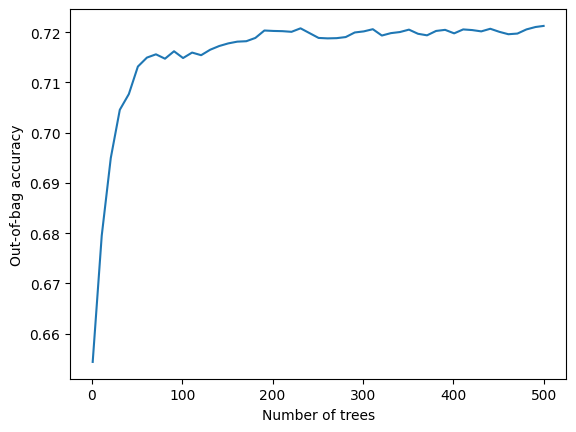

In [96]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag accuracy")
pass

In [97]:
p = model_1.predict(test_ds)

#Fish for best cut
for cut in np.arange(0.25, .8, .05):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    N = len(p)
    for i in range(N):
        tru = larr2[i] == 1
        prd = p[i] > cut
        if tru and prd == tru:
            tp = tp + 1
        if tru and prd != tru:
            fn = fn + 1
        if tru == False and prd == tru:
            tn = tn + 1
        if tru == False and prd != tru:
            fp = fp + 1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    print("cut: {}, acc: {}, prec: {}, rec: {}, f1: {}".format(cut, (tp+tn)/N, precision, recall, f1_score))

29/29 [==============================] - 1s 16ms/step
cut: 0.25, acc: 0.5737988247493951, prec: 0.3650352243233222, rec: 0.8778421756576015, f1: 0.5156475055650125
cut: 0.3, acc: 0.6221914967162115, prec: 0.39108494533221194, rec: 0.8292465448060633, f1: 0.531504500642949
cut: 0.35, acc: 0.6595229865191843, prec: 0.41503579952267305, rec: 0.775300936246099, f1: 0.5406497745997203
cut: 0.39999999999999997, acc: 0.6910934439451549, prec: 0.440359477124183, rec: 0.7209094962104324, f1: 0.5467455621301776
cut: 0.44999999999999996, acc: 0.7189768406498445, prec: 0.4690656565656566, rec: 0.6625055728934462, f1: 0.5492515246719645
cut: 0.49999999999999994, acc: 0.7377578061988709, prec: 0.4938820912124583, rec: 0.5938475256353098, f1: 0.5392712550607288
cut: 0.5499999999999999, acc: 0.7560778891577371, prec: 0.528099910793934, rec: 0.5278644672313866, f1: 0.5279821627647715
cut: 0.5999999999999999, acc: 0.7695587049199216, prec: 0.5676880222841225, rec: 0.45430227374052606, f1: 0.504705299653